# Setup Packages

In [1]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(SingleCellExperiment)
    library(tidyverse)
    library(reticulate)
    library(BiocParallel)
    library(logger)
    library(showtext)
    library(basilisk)
    library(zellkonverter)
})
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

# Read Data 

In [135]:
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc.rds")

# Feature Selection

In [136]:
keep <- rowData(sce)$Biotype == "protein_coding"
dec <- modelGeneVar(sce, block = sce$donor, subset.row = keep, min.mean = 1, density.weights=FALSE)
hvgs <- getTopHVGs(dec, n = 3000)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


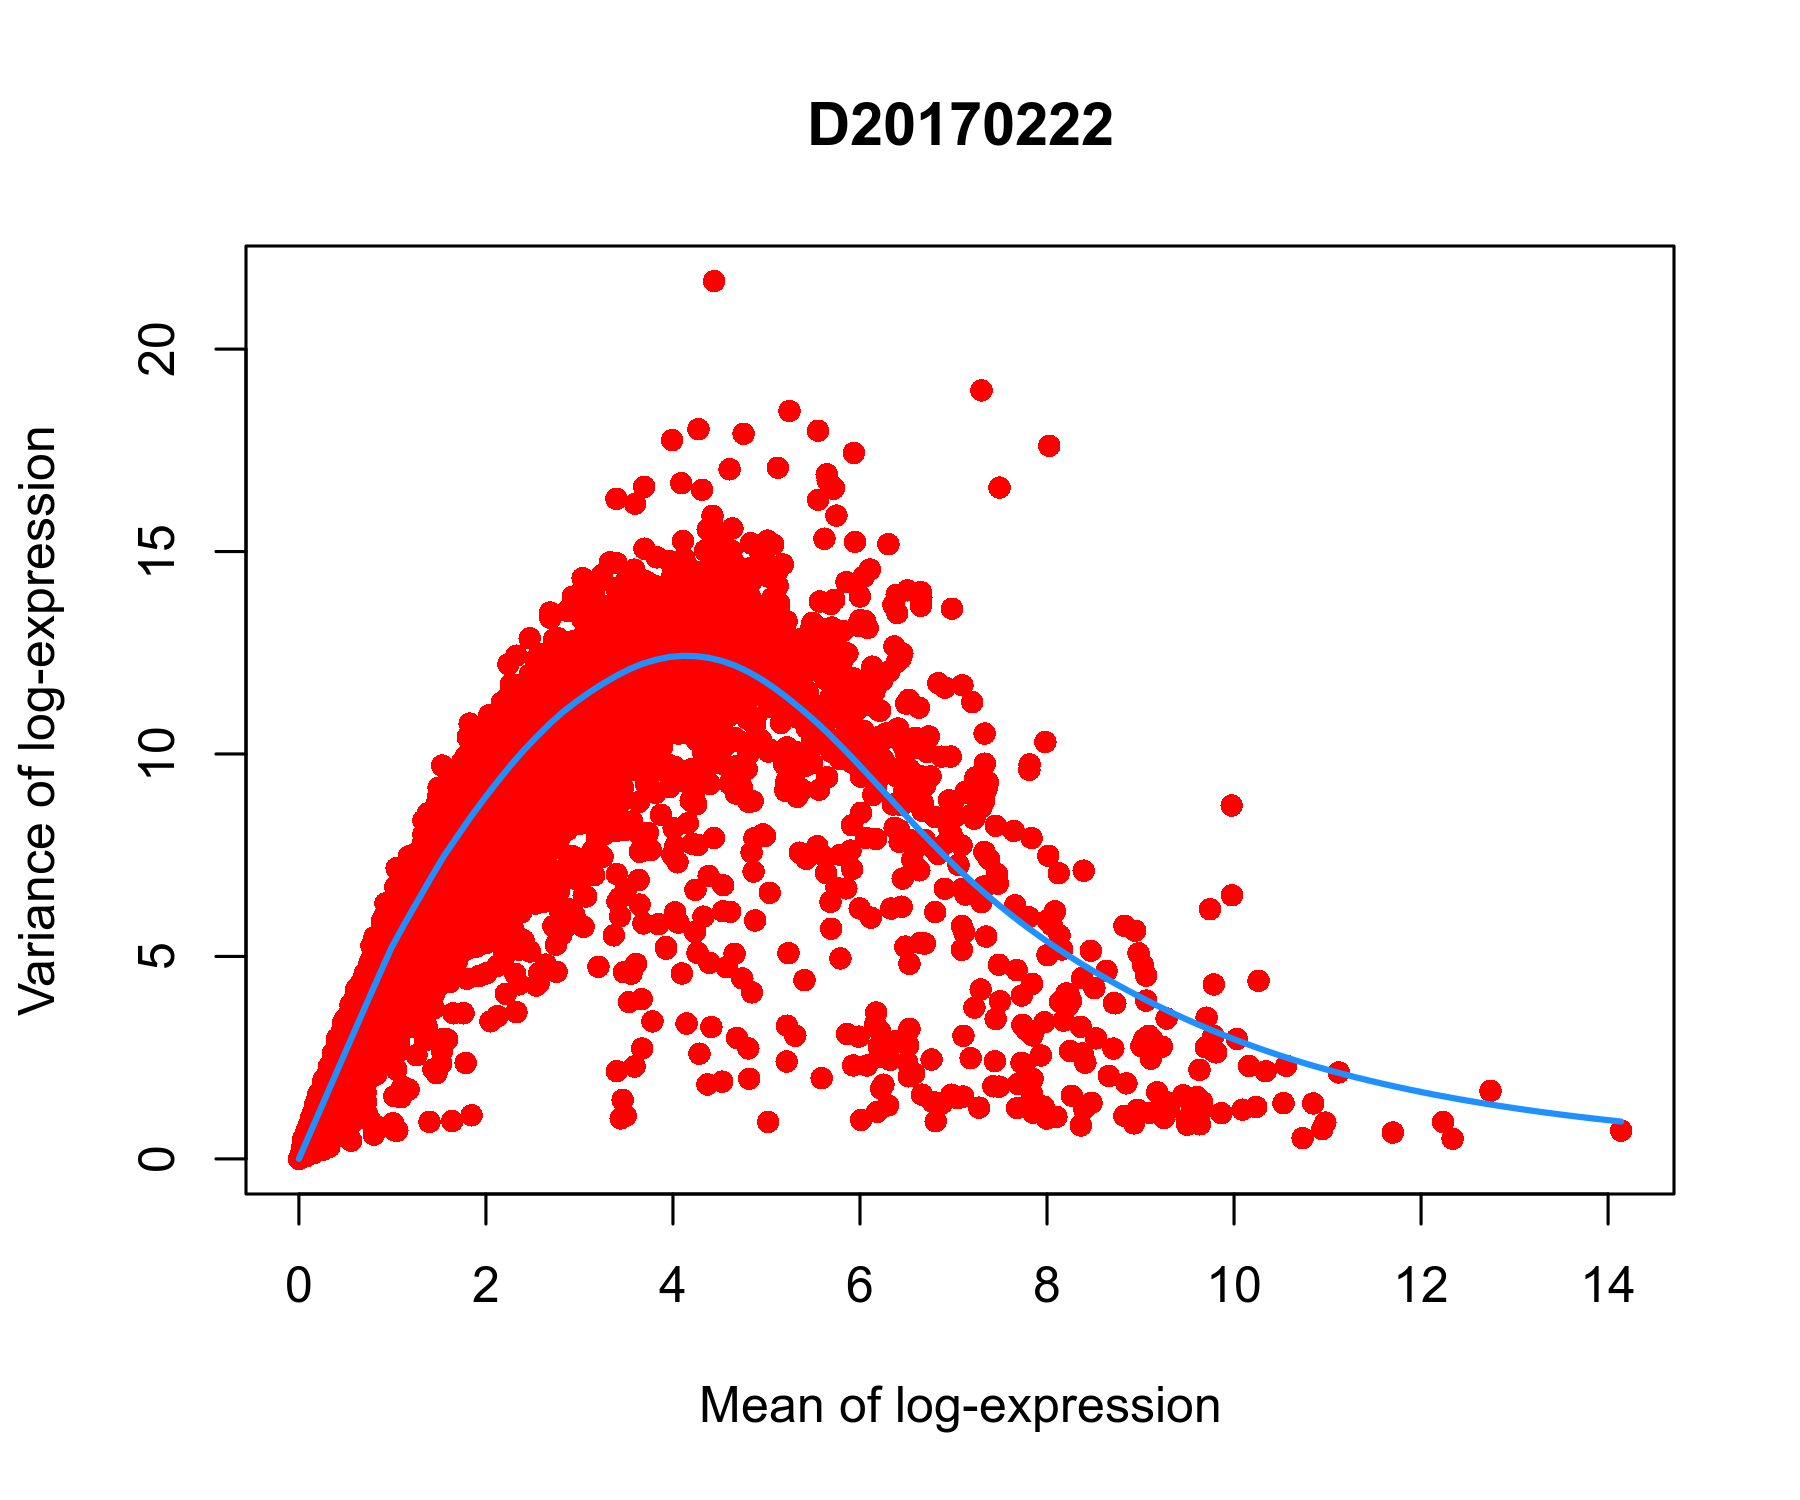

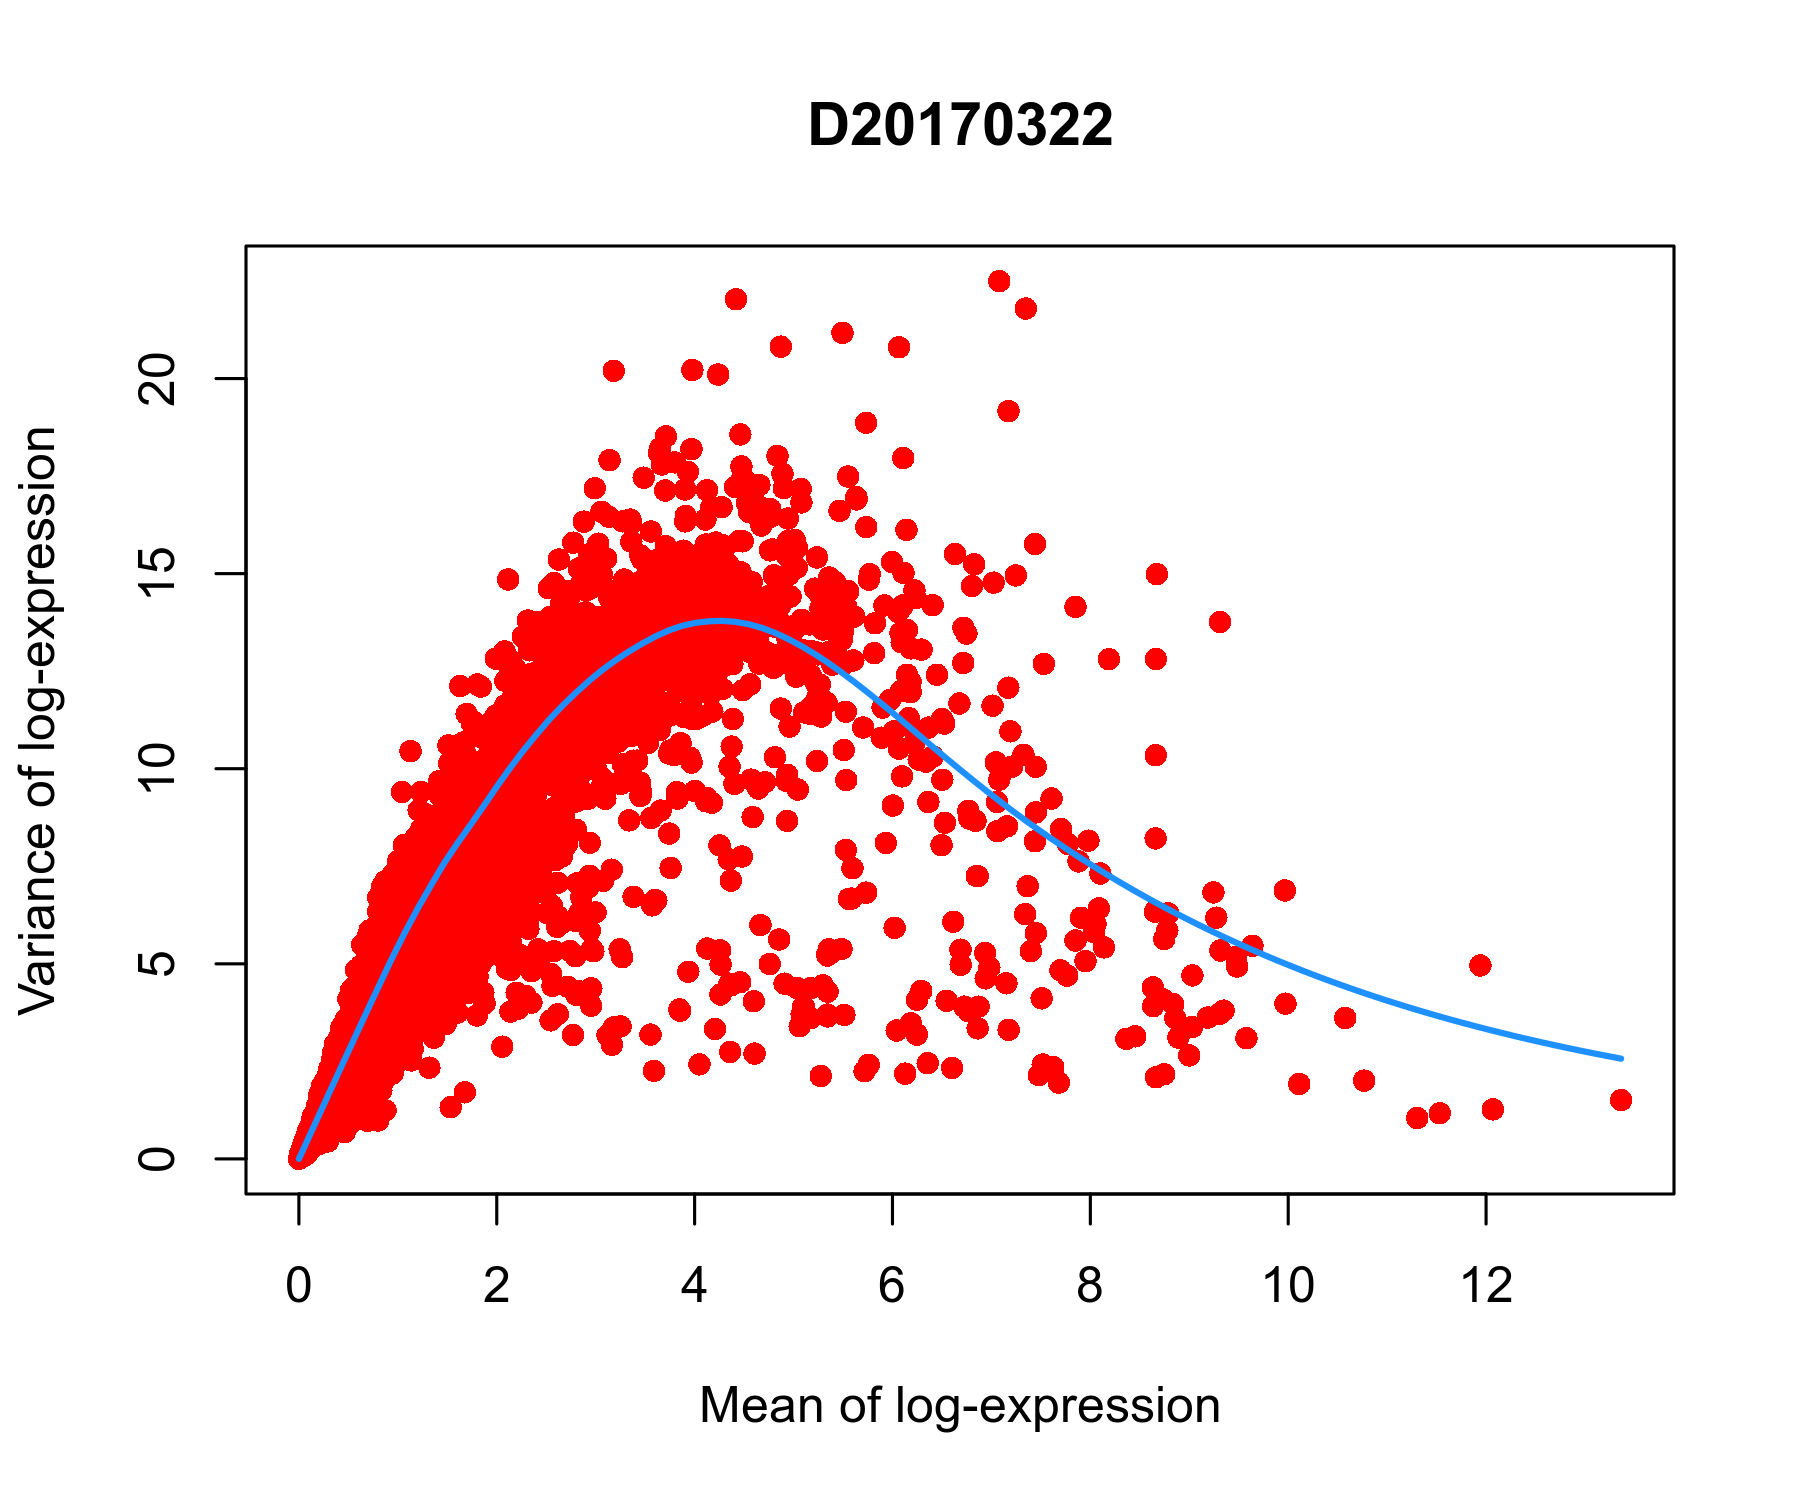

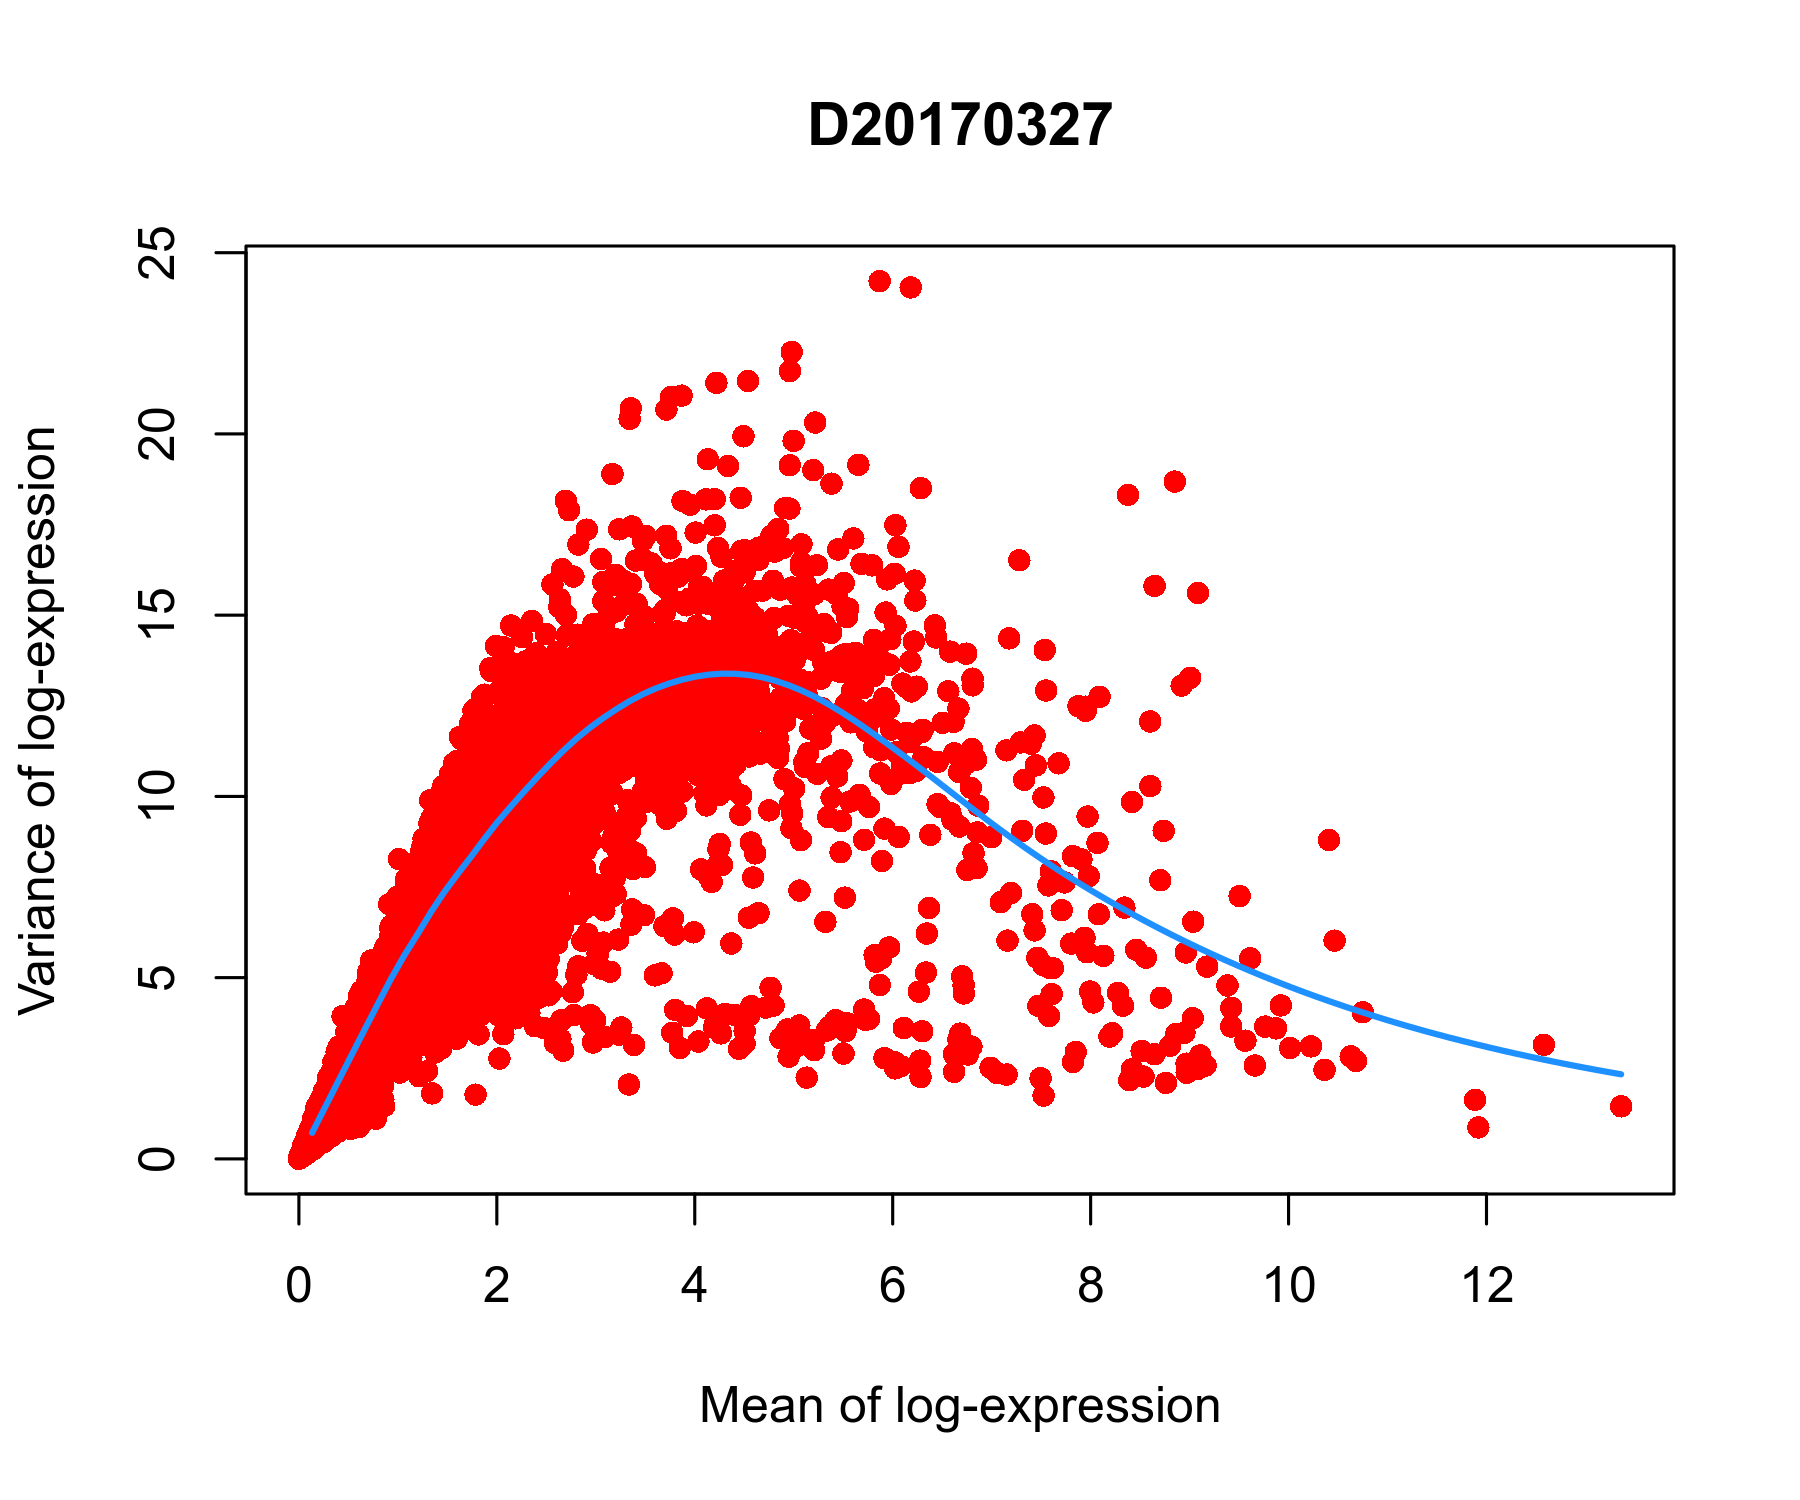

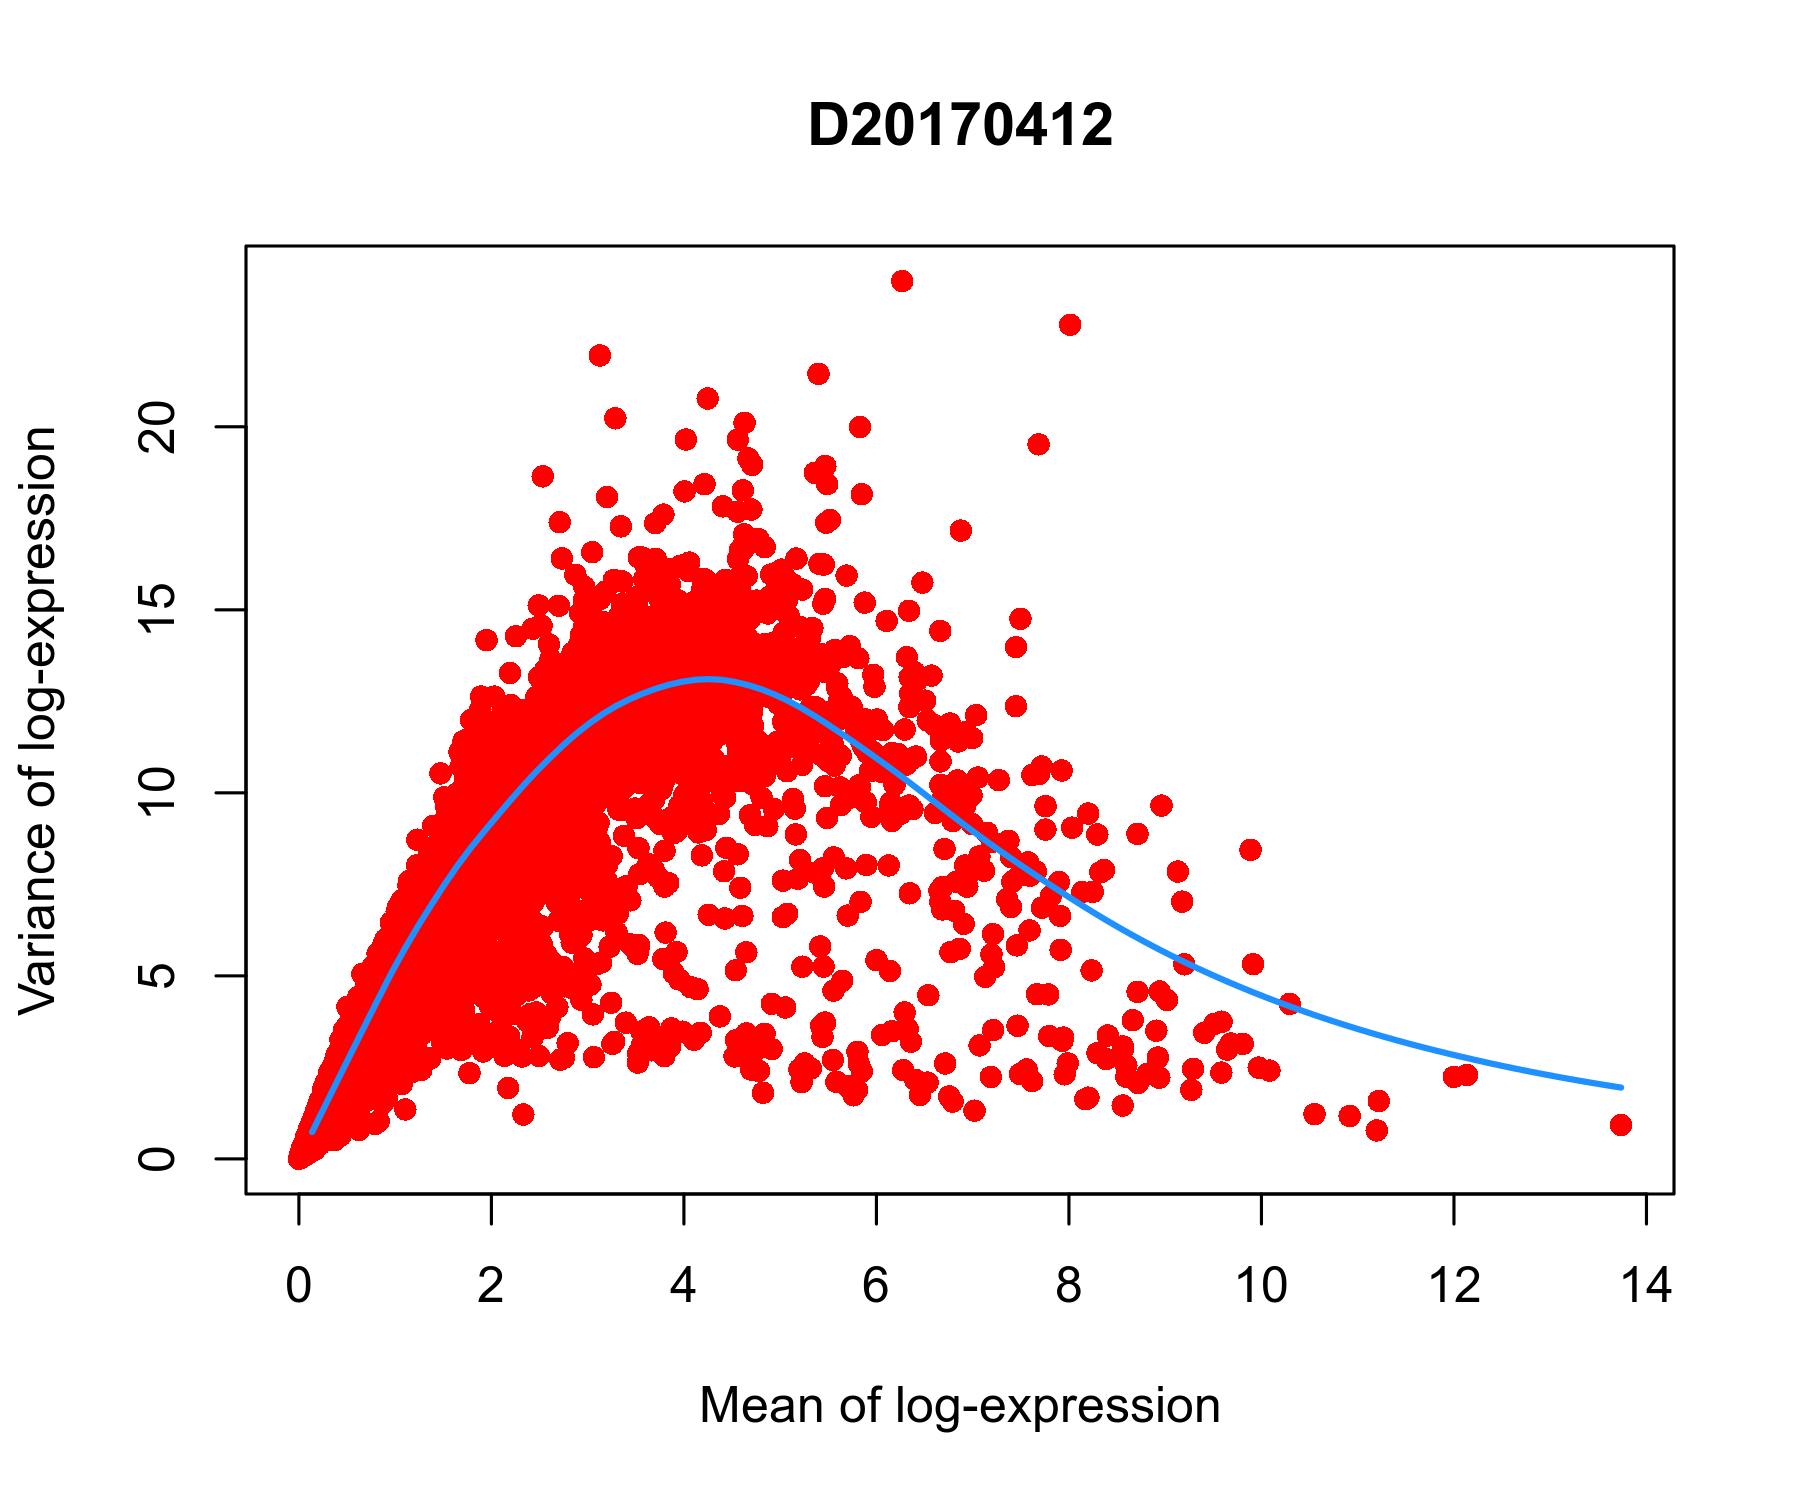

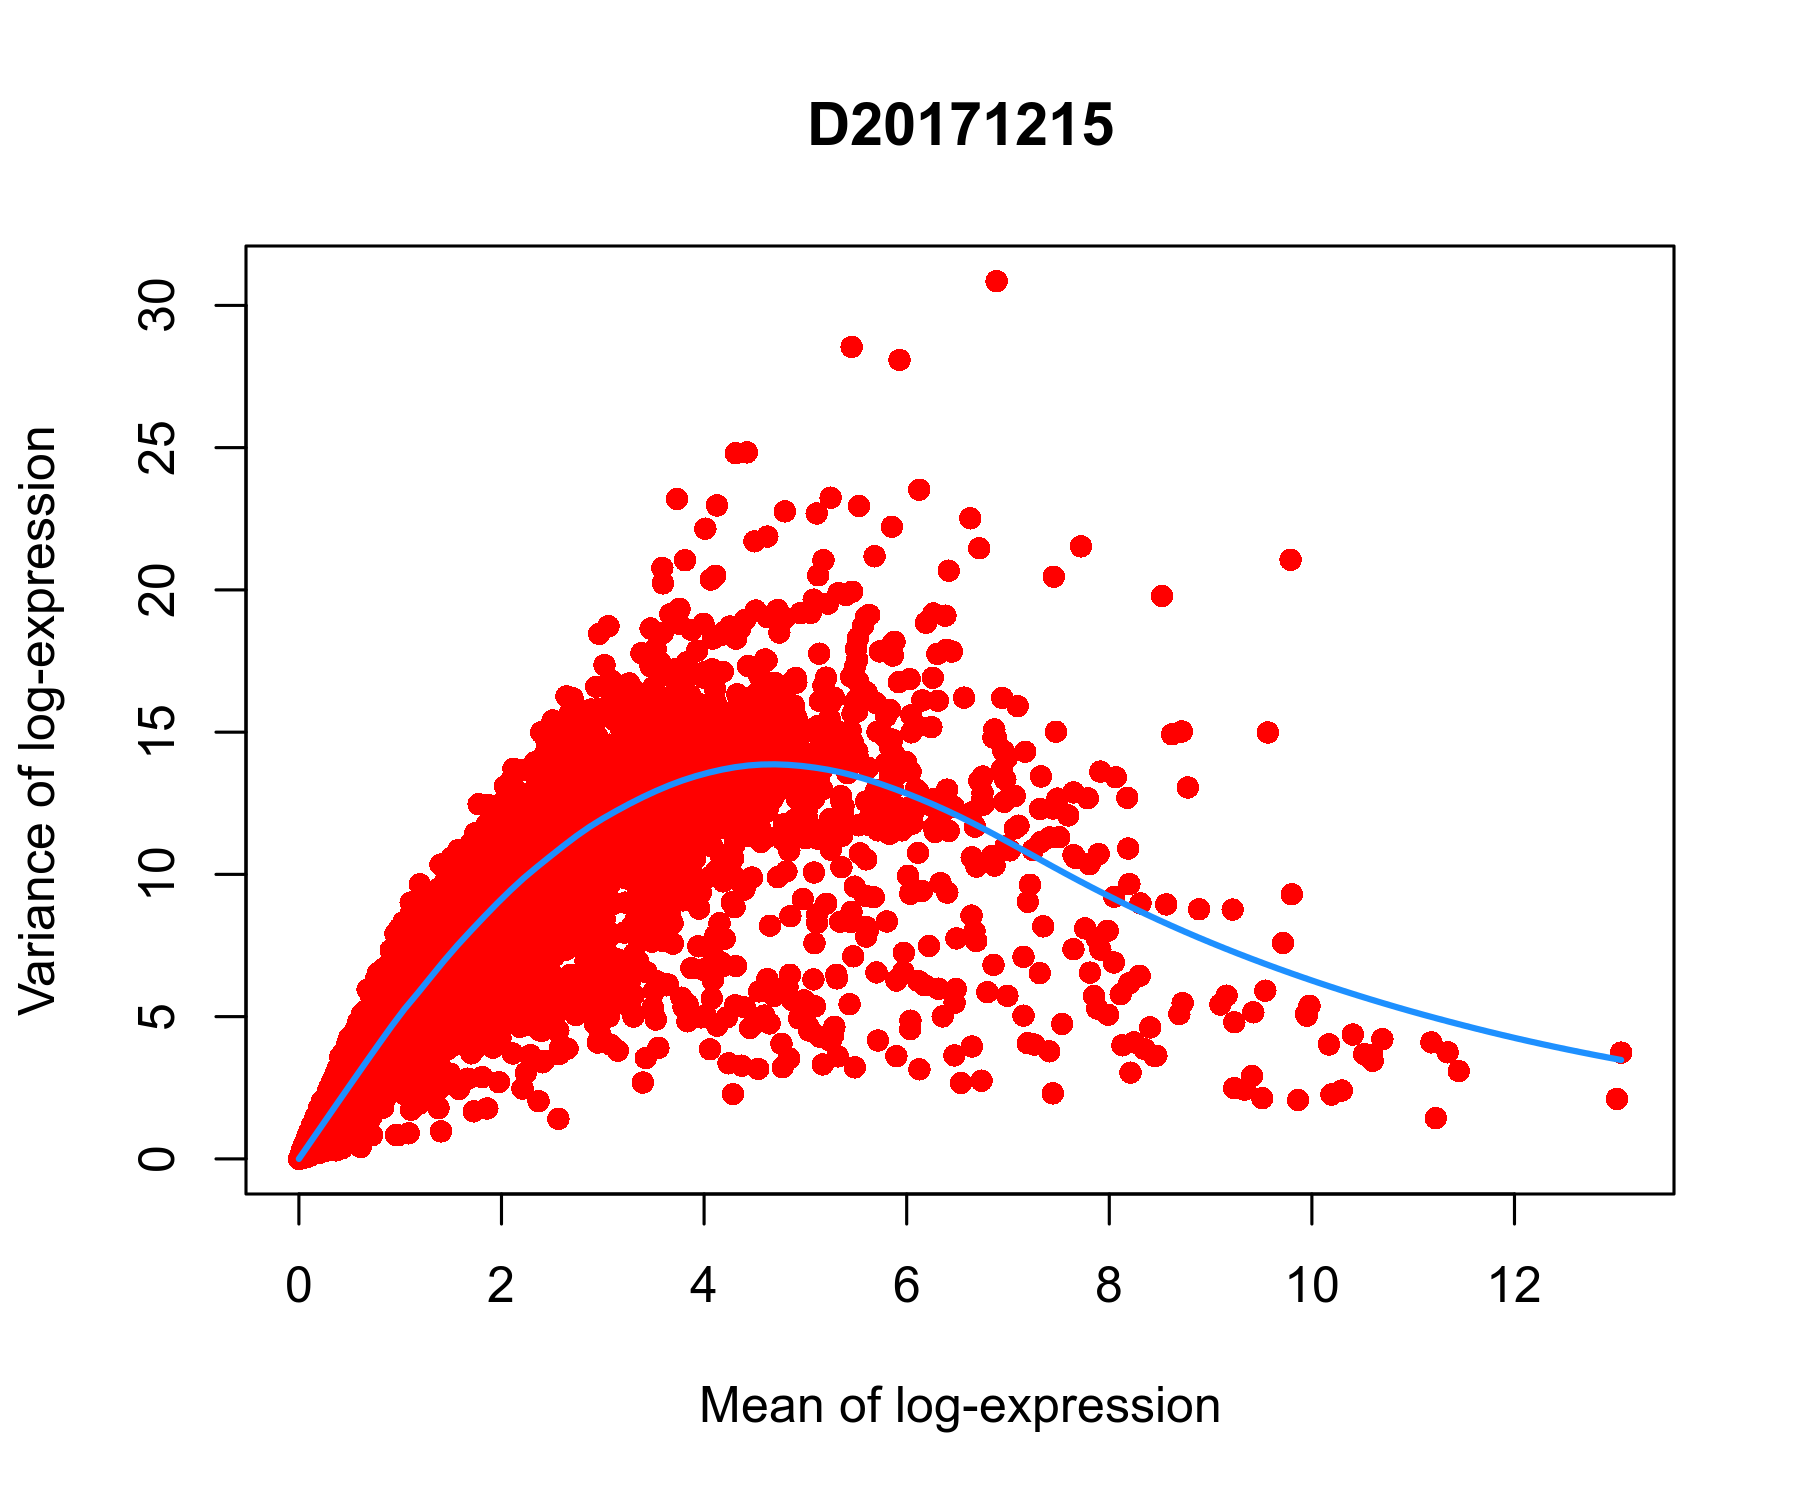

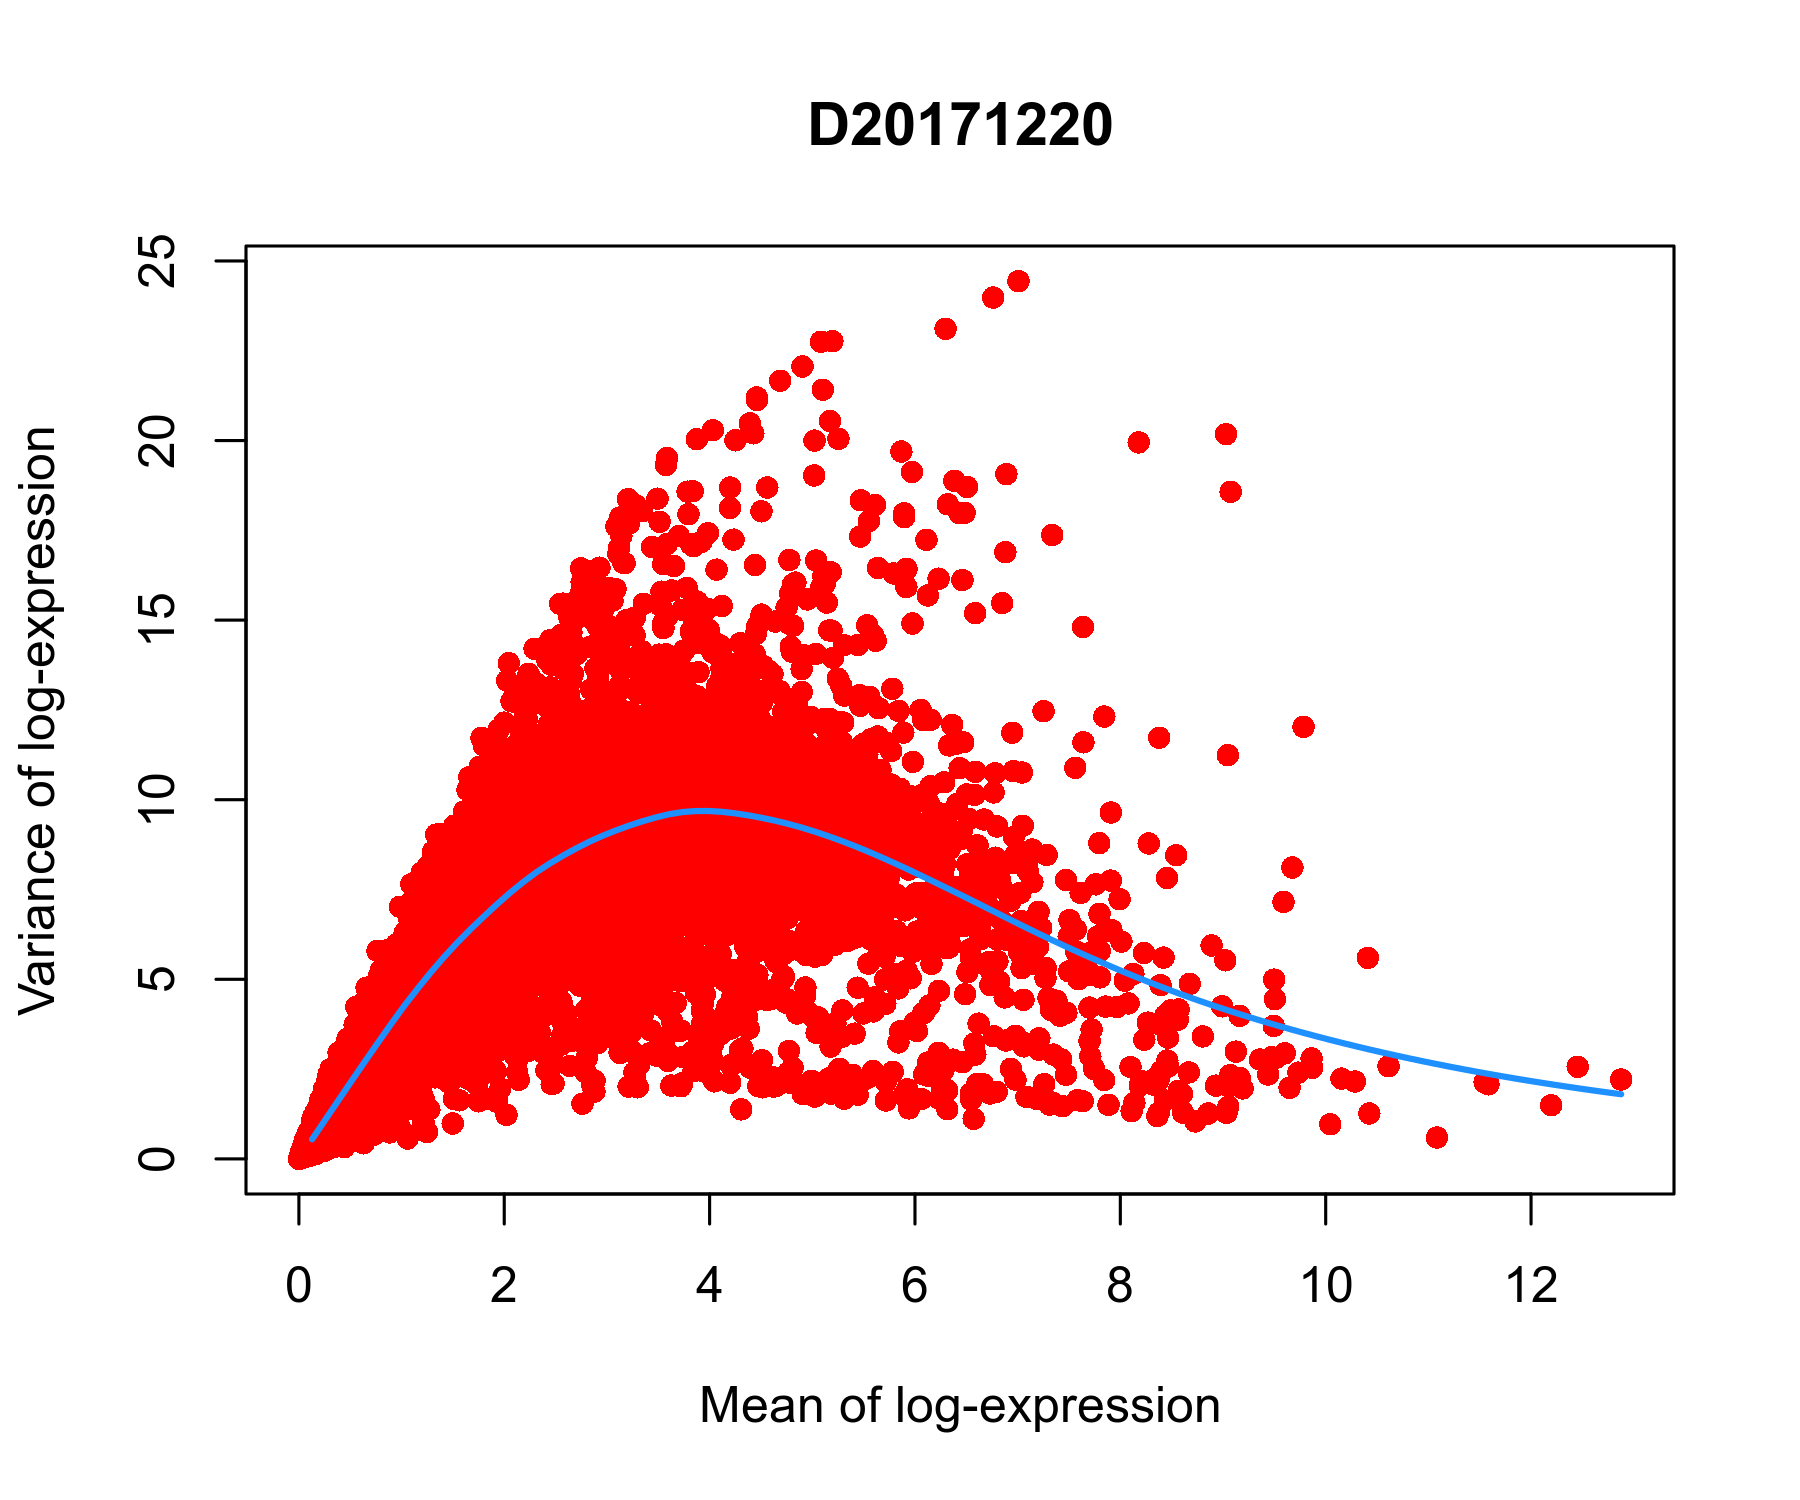

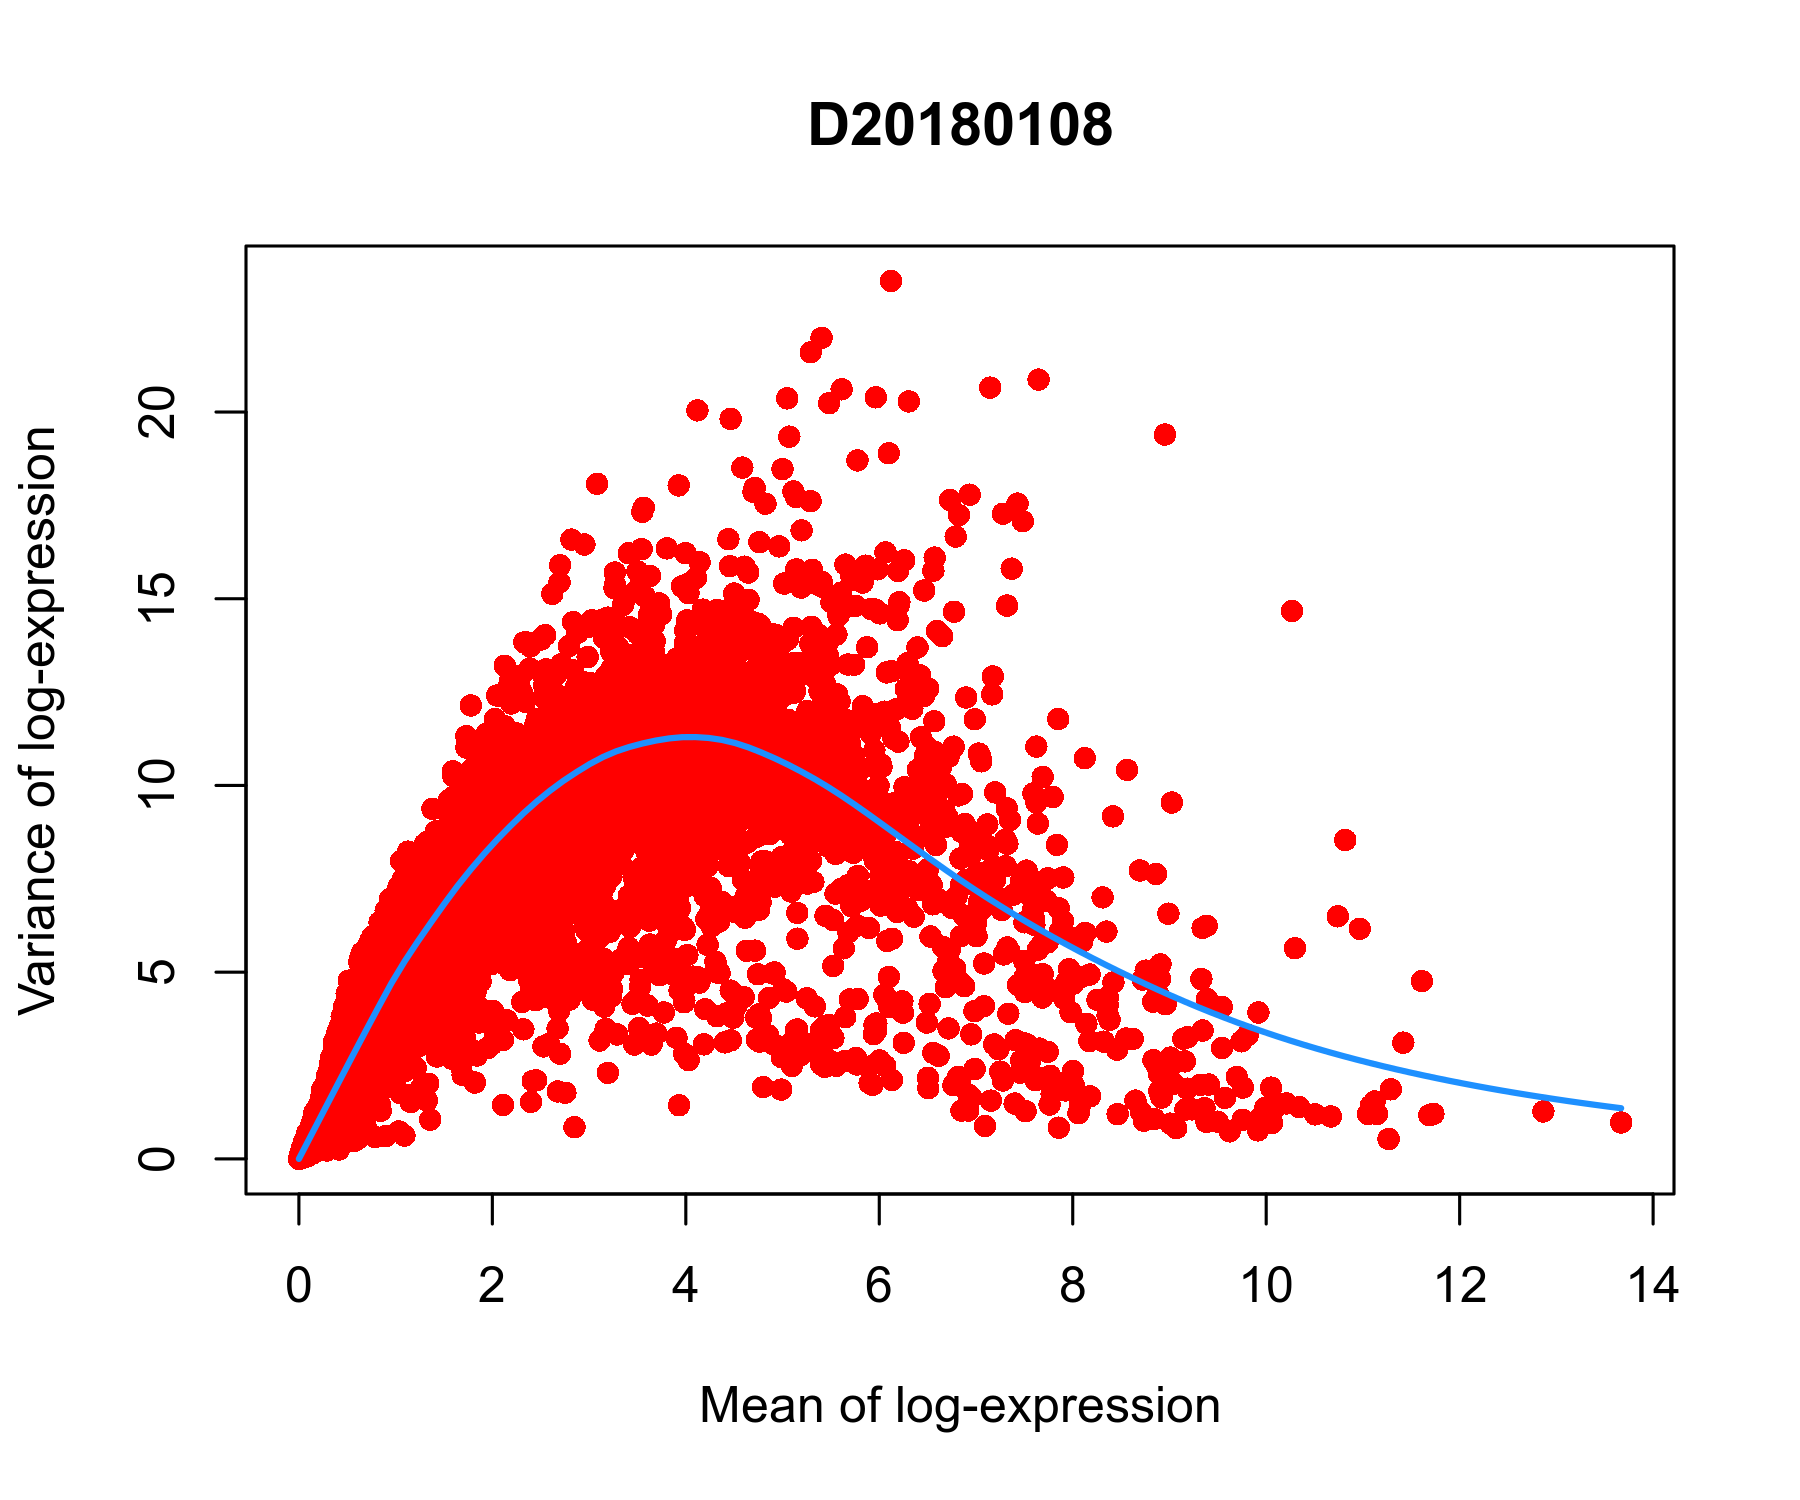

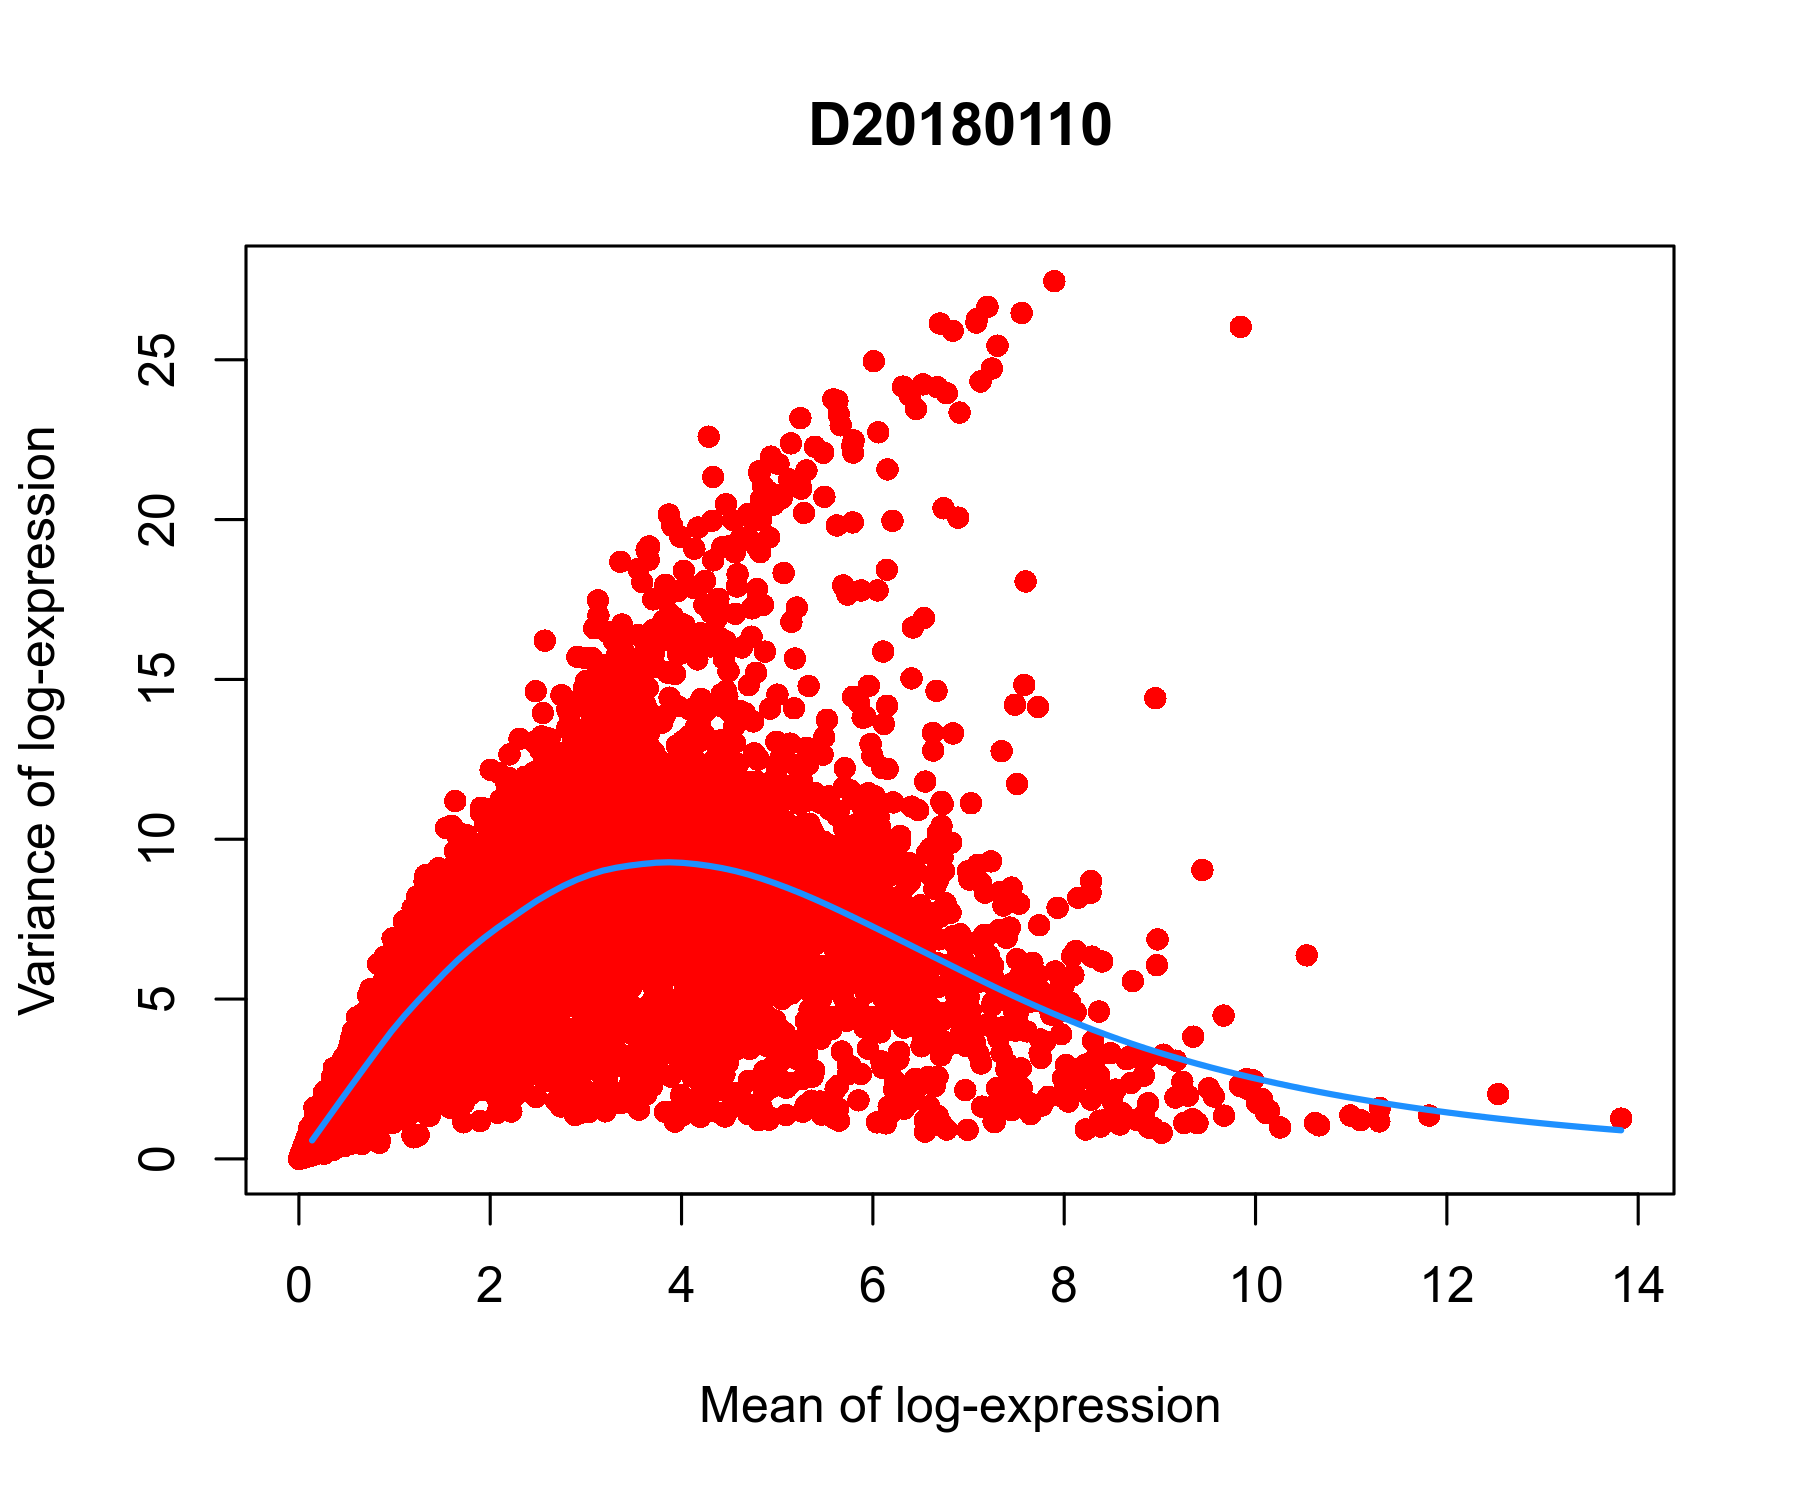

In [137]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)
blocked.stats <- dec$per.block
for (i in colnames(blocked.stats)) {
    current <- blocked.stats[[i]]
    plot(current$mean, current$total, main=i, pch=16, cex=0.5,
        xlab="Mean of log-expression", ylab="Variance of log-expression")
    curfit <- metadata(current)
    points(curfit$mean, curfit$var, col="red", pch=16)
    curve(curfit$trend(x), col='dodgerblue', add=TRUE, lwd=2) 
}

# Clustering by scanpy

In [138]:
adata_sce <- zellkonverter::SCE2AnnData(sce, X_name = "logcounts")
sc <- import("scanpy")
adata_sce$var['highly_variable'] <- rownames(adata_sce$var) %in% hvgs
log_info("Run PCA")
sc$tl$pca(adata_sce, use_highly_variable=TRUE)
sc$pp$neighbors(adata_sce, n_pcs = 50L, use_rep = "X_pca" )
log_info("Run UMAP")
sc$tl$umap(adata_sce)
log_info("Run Leiden")
sc$tl$leiden(adata_sce, resolution = .8)

In [221]:
log_info("Convert back to sce")
sce <- zellkonverter::AnnData2SCE(adata_sce)

Note: Using stored X_name value 'logcounts'



In [222]:
sce$leiden_global <- case_when(nchar(as.character(sce$leiden)) == 1 ~ paste0("C0", as.character(sce$leiden)), 
         nchar(as.character(sce$leiden)) > 1  ~ paste0("C", as.character(sce$leiden)))


In [223]:
sce$leiden <- NULL

In [224]:
reducedDimNames(sce) <- c("PCA", "UMAP")

# Visualization

## Prepare data

In [243]:
table(sce$leiden_global, sce$tissue)

     
      Blood Normal Tumor TumorCore
  C00    36    265   479         0
  C01     0      0   756         0
  C02   463     96    98         0
  C03     0     45   449       156
  C04     0    170   408         1
  C05   440     42    25         0
  C06   430     18    10         0
  C07   347     12    11         0
  C08     0     29    80       254
  C09    42    160   160         0
  C10     0      6   339        11
  C11    11    194   113         0
  C12     3    122   190         0
  C13     2    229    78         0
  C14     0    244    26         0
  C15    35     42   192         1
  C16     0      0   102       165
  C17     0     45    75        80
  C18   141     28    29         0
  C19     0      0   190         1
  C20     0     20   167         0
  C21     0      5   169         0
  C22     0     47    73        16
  C23     0     59    59         0
  C24     4     63    51         0
  C25     5     22    55         0
  C26     2      6    50         0
  C27     0   

In [232]:
plotDF <- makePerCellDF(sce, use_dimred = T)
plotLabelDF <- plotDF %>% 
    group_by(leiden_global) %>%
    summarise(UMAP.1 = median(UMAP.1),
              UMAP.2 = median(UMAP.2)) %>% 
    mutate(label = leiden_global)

## Prepare colors

In [5]:
set.seed(319)
pal <- ggsci::pal_futurama()(10)
cols <- colorRampPalette(pal)(length(unique(sce$leiden_global)))
cols <- sample(cols)

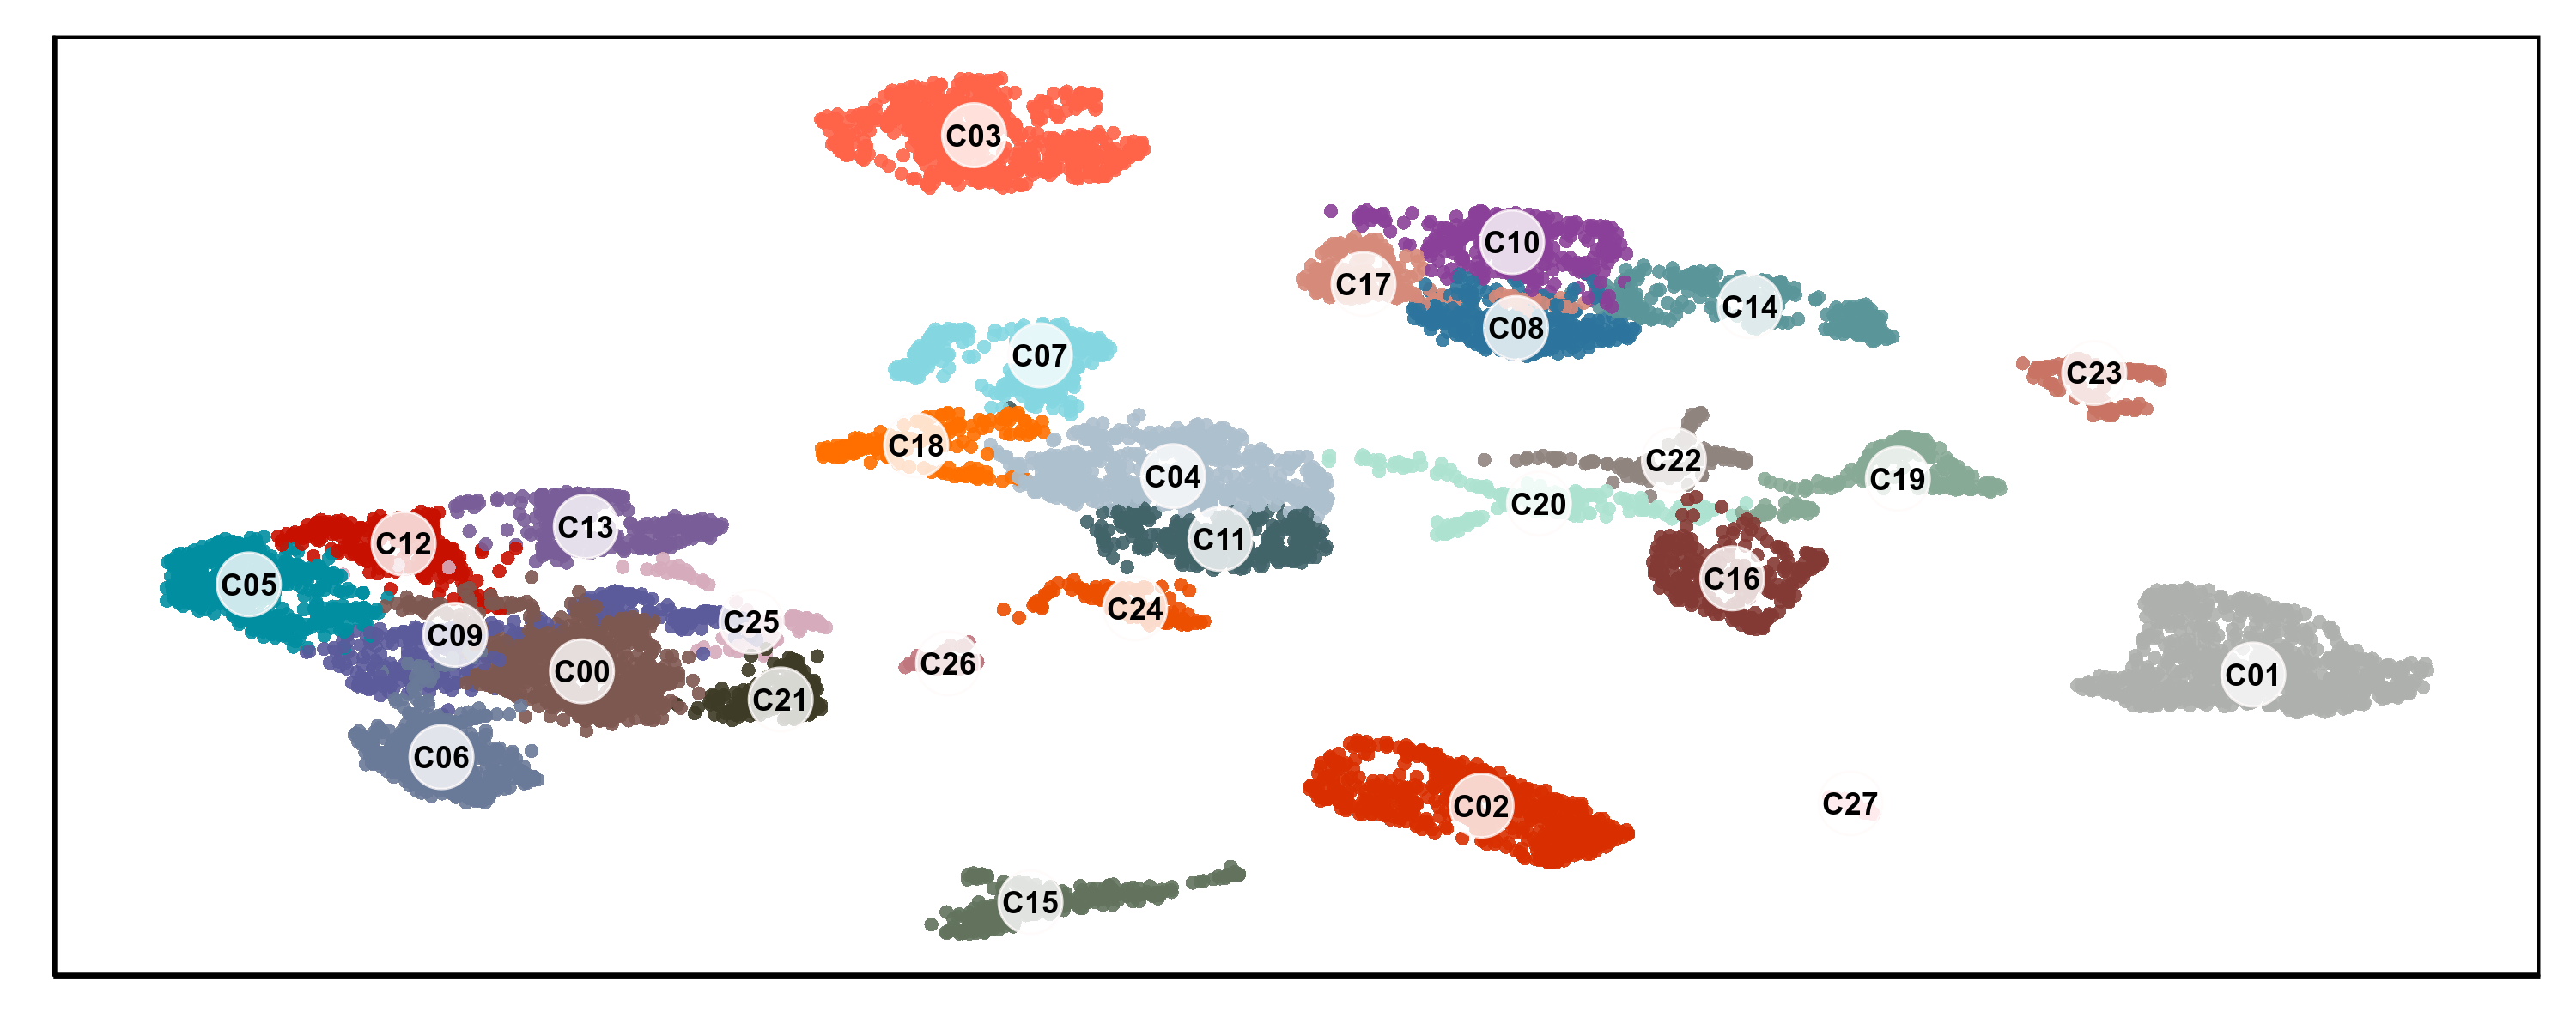

In [234]:
p1 <- ggcells(sce, aes(x=UMAP.1, y = UMAP.2) ) + 
    geom_point(aes(color = leiden_global), shape = 16, alpha = 0.9, size = 1.5) +
    geom_point(data = plotLabelDF, shape = 21, fill = 'white', alpha = .8, color = 'snow', size = 8) +
    geom_text(data = plotLabelDF, aes(label = label), color = 'black', size = 3, fontface = 'bold') +
    scale_color_manual(values = cols, guide = guide_legend(title = NULL,override.aes = list(size = 4))) + 
    ggpubr::theme_pubr(base_size = 20) +
    theme( legend.position = "none", axis.ticks = element_blank(), axis.text = element_blank(), axis.title = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1))
p1
#ggsave(p1, filename =  "./figures/UMAP_colorByGobalClustering_withLegend.pdf", height = 12, width = 10)

# Find Markers

In [190]:
keep <- rowData(sce)$Biotype == 'protein_coding'
markers <- suppressWarnings(findMarkers(sce[keep, ], groups = sce$leiden_global, min.prop = .1, lfc = 1, direction = 'up'))

In [191]:
top_markers <- lapply(markers, function(df) {
    df <- as.data.frame(df[which(df$Top <= 10),])
    cbind(gene = rownames(df), df)
    
})

In [192]:
openxlsx::write.xlsx(top_markers, file = "./TopMarkers_globalClustering_lfc1_Top10.xlsx")

# Marker-based Annotation

In [147]:
sce_old <- readRDS('../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds')

In [149]:
ov_cells <- intersect(colnames(sce), colnames(sce_old))

In [251]:
colData(sce)[ov_cells,"old_anno"] <- colData(sce_old)[ov_cells, "celltype"]

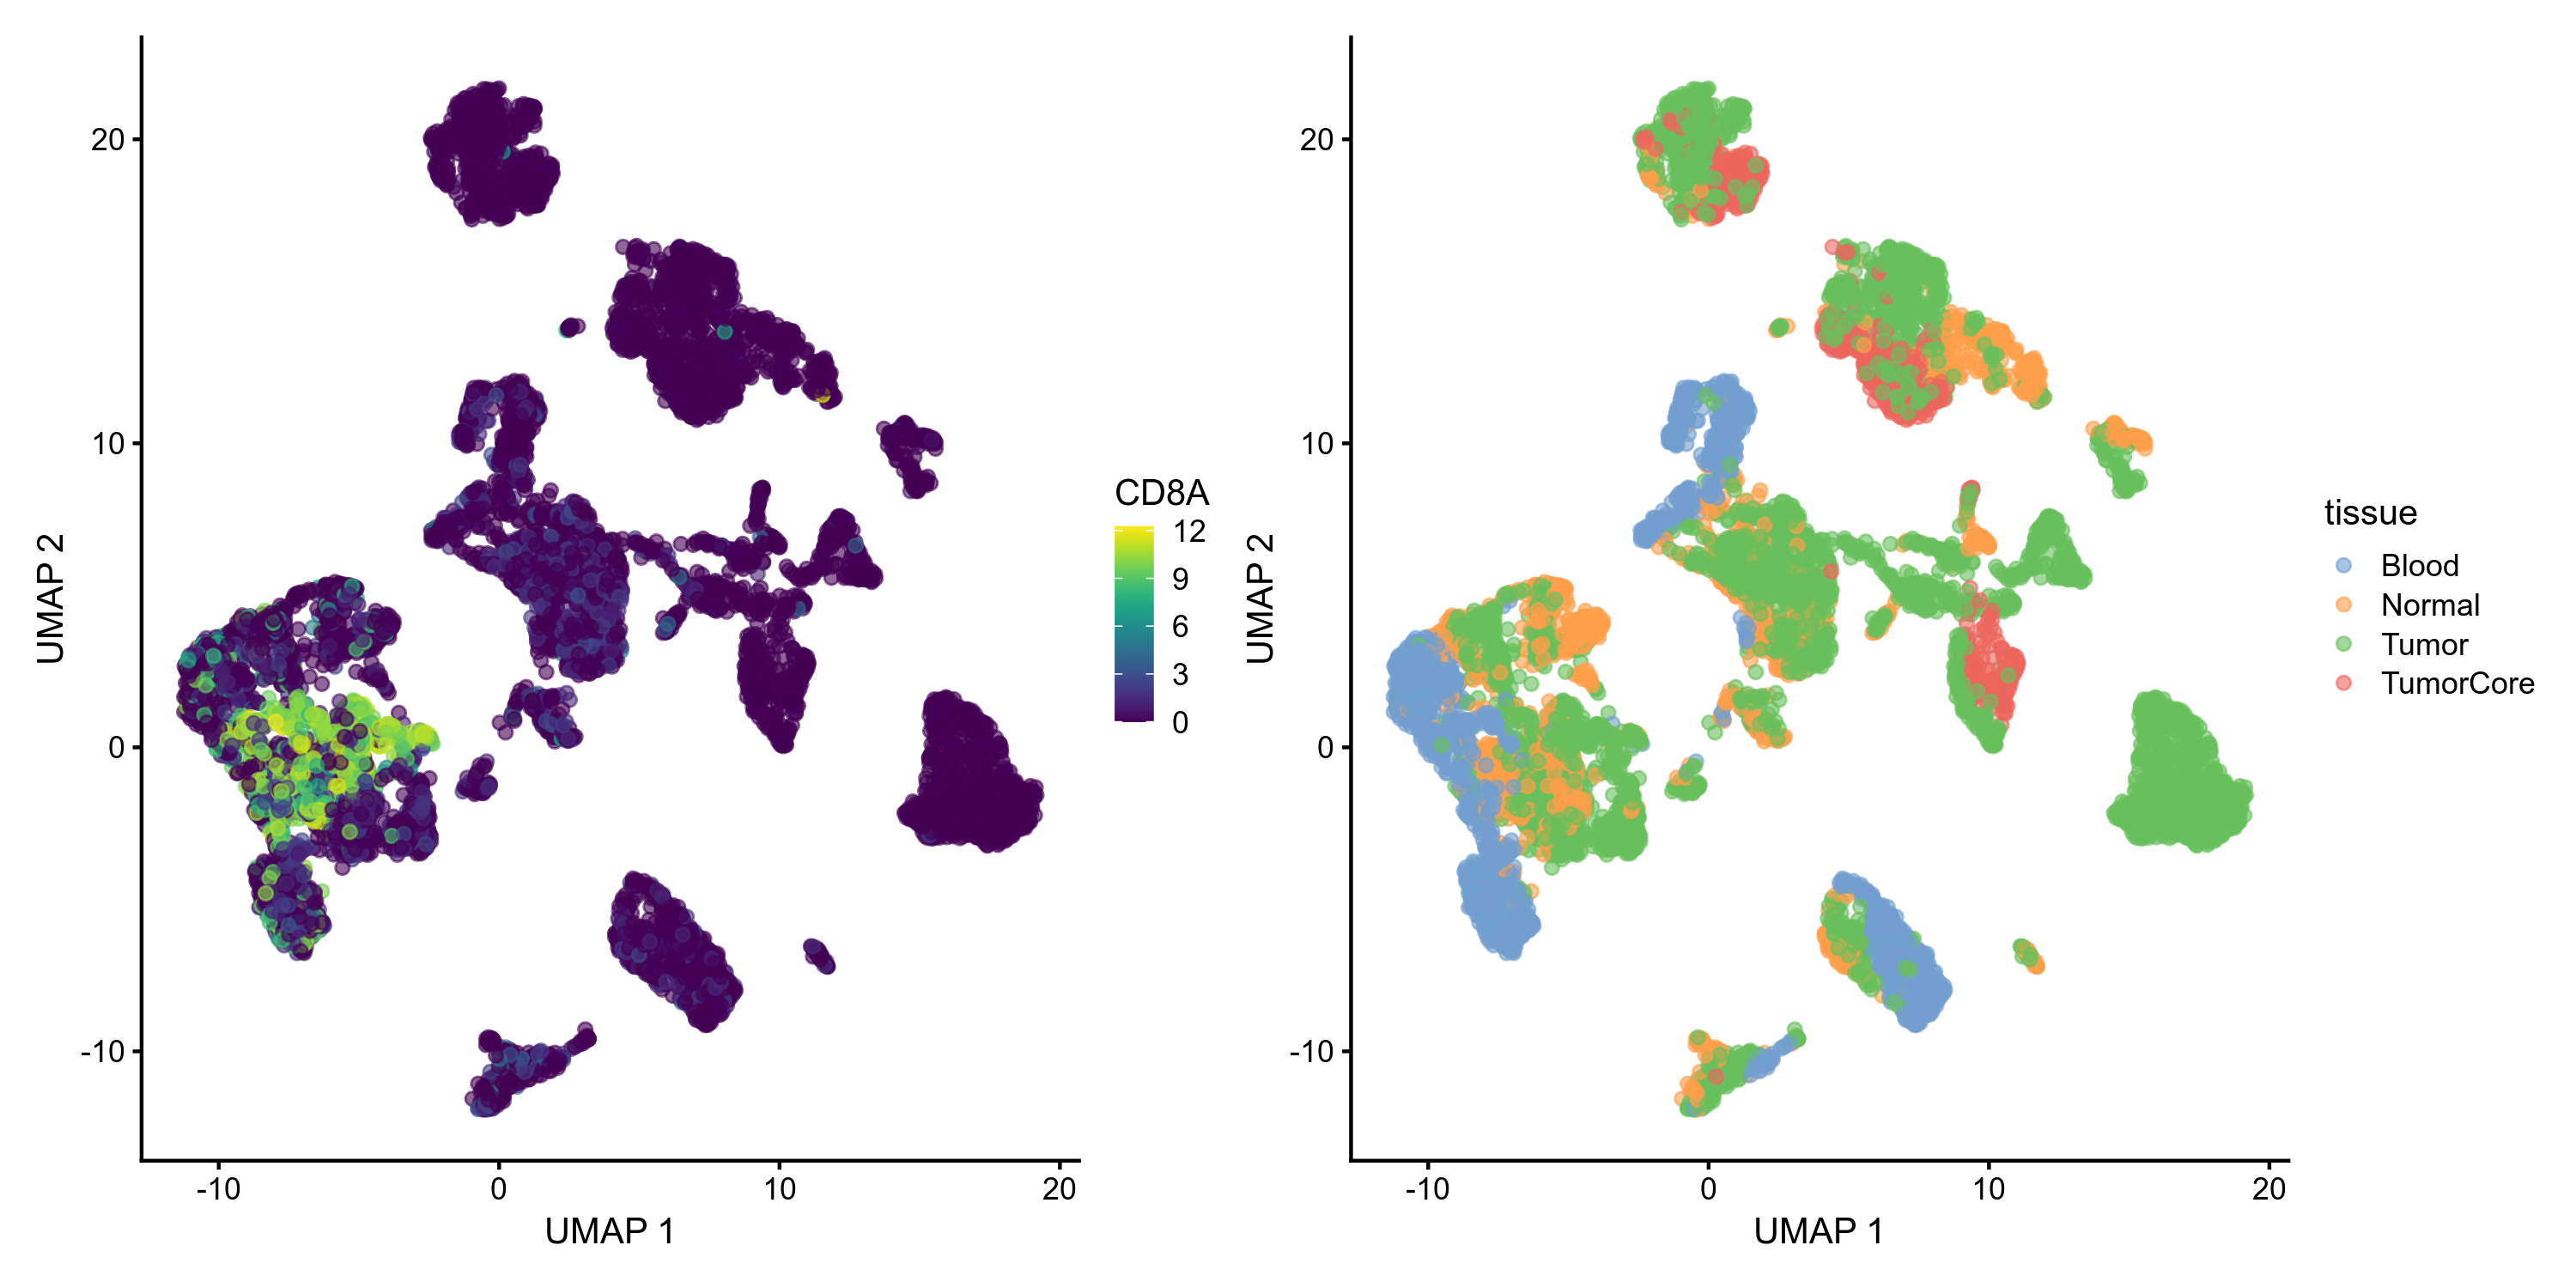

In [162]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by="CD8A")
p2 <- plotUMAP(sce, colour_by="tissue")
p1 + p2

In [255]:
table(sce$leiden_global, sce$tissue)

     
      Blood Normal Tumor TumorCore
  C00    36    265   479         0
  C01     0      0   756         0
  C02   463     96    98         0
  C03     0     45   449       156
  C04     0    170   408         1
  C05   440     42    25         0
  C06   430     18    10         0
  C07   347     12    11         0
  C08     0     29    80       254
  C09    42    160   160         0
  C10     0      6   339        11
  C11    11    194   113         0
  C12     3    122   190         0
  C13     2    229    78         0
  C14     0    244    26         0
  C15    35     42   192         1
  C16     0      0   102       165
  C17     0     45    75        80
  C18   141     28    29         0
  C19     0      0   190         1
  C20     0     20   167         0
  C21     0      5   169         0
  C22     0     47    73        16
  C23     0     59    59         0
  C24     4     63    51         0
  C25     5     22    55         0
  C26     2      6    50         0
  C27     0   

In [282]:
leiden2celltype <- c(
  "C00" = 'T Cell',
  "C01" = 'Hepatocytes',
  "C02" = "B Cell",
  "C03" = "Mesenchyme", 
  "C04" = "Macrophage",
  "C05" = "Blood CD16+ NK",
  "C06" = "T Cell",
  "C07" = 'CD14+ Monocytes',
  "C08" = 'Endothelial',
  "C09" = 'T Cell',
  "C10" = 'Endothelial',
  "C11" = "CD1c+ Dendritic Cell",
  "C12" = "Tissue Resident CD16+ NK",
  "C13" = 'CD16- NK',
  "C14" = "Endothelial",
  "C15" = "Plasma B Cell",
  "C16" = 'Hepatocytes',
  "C17" = "Endothelial",
  "C18" = "CD16+ Monocytes",
  "C19" = 'Hepatocytes',
  "C20" = 'Hepatocytes',
  "C21" = "T Cell",
  "C22" = "Hepatocytes",
  "C23" = "Liver bi-potent/Cholangiocytes",
  "C24" = "CLEC9A+/LAMP3+ Dendritic Cell",
  "C25" = "Proliferative T/NK",
  "C26" = "Mast Cell" ,
  "C27" = "ILCs" ,
  "C28" = "Doublet_D20170327" )

In [283]:
sce$leiden_global_celltype <- plyr::mapvalues(sce$leiden_global, from = names(leiden2celltype), to = leiden2celltype)

The following `from` values were not present in `x`: C28



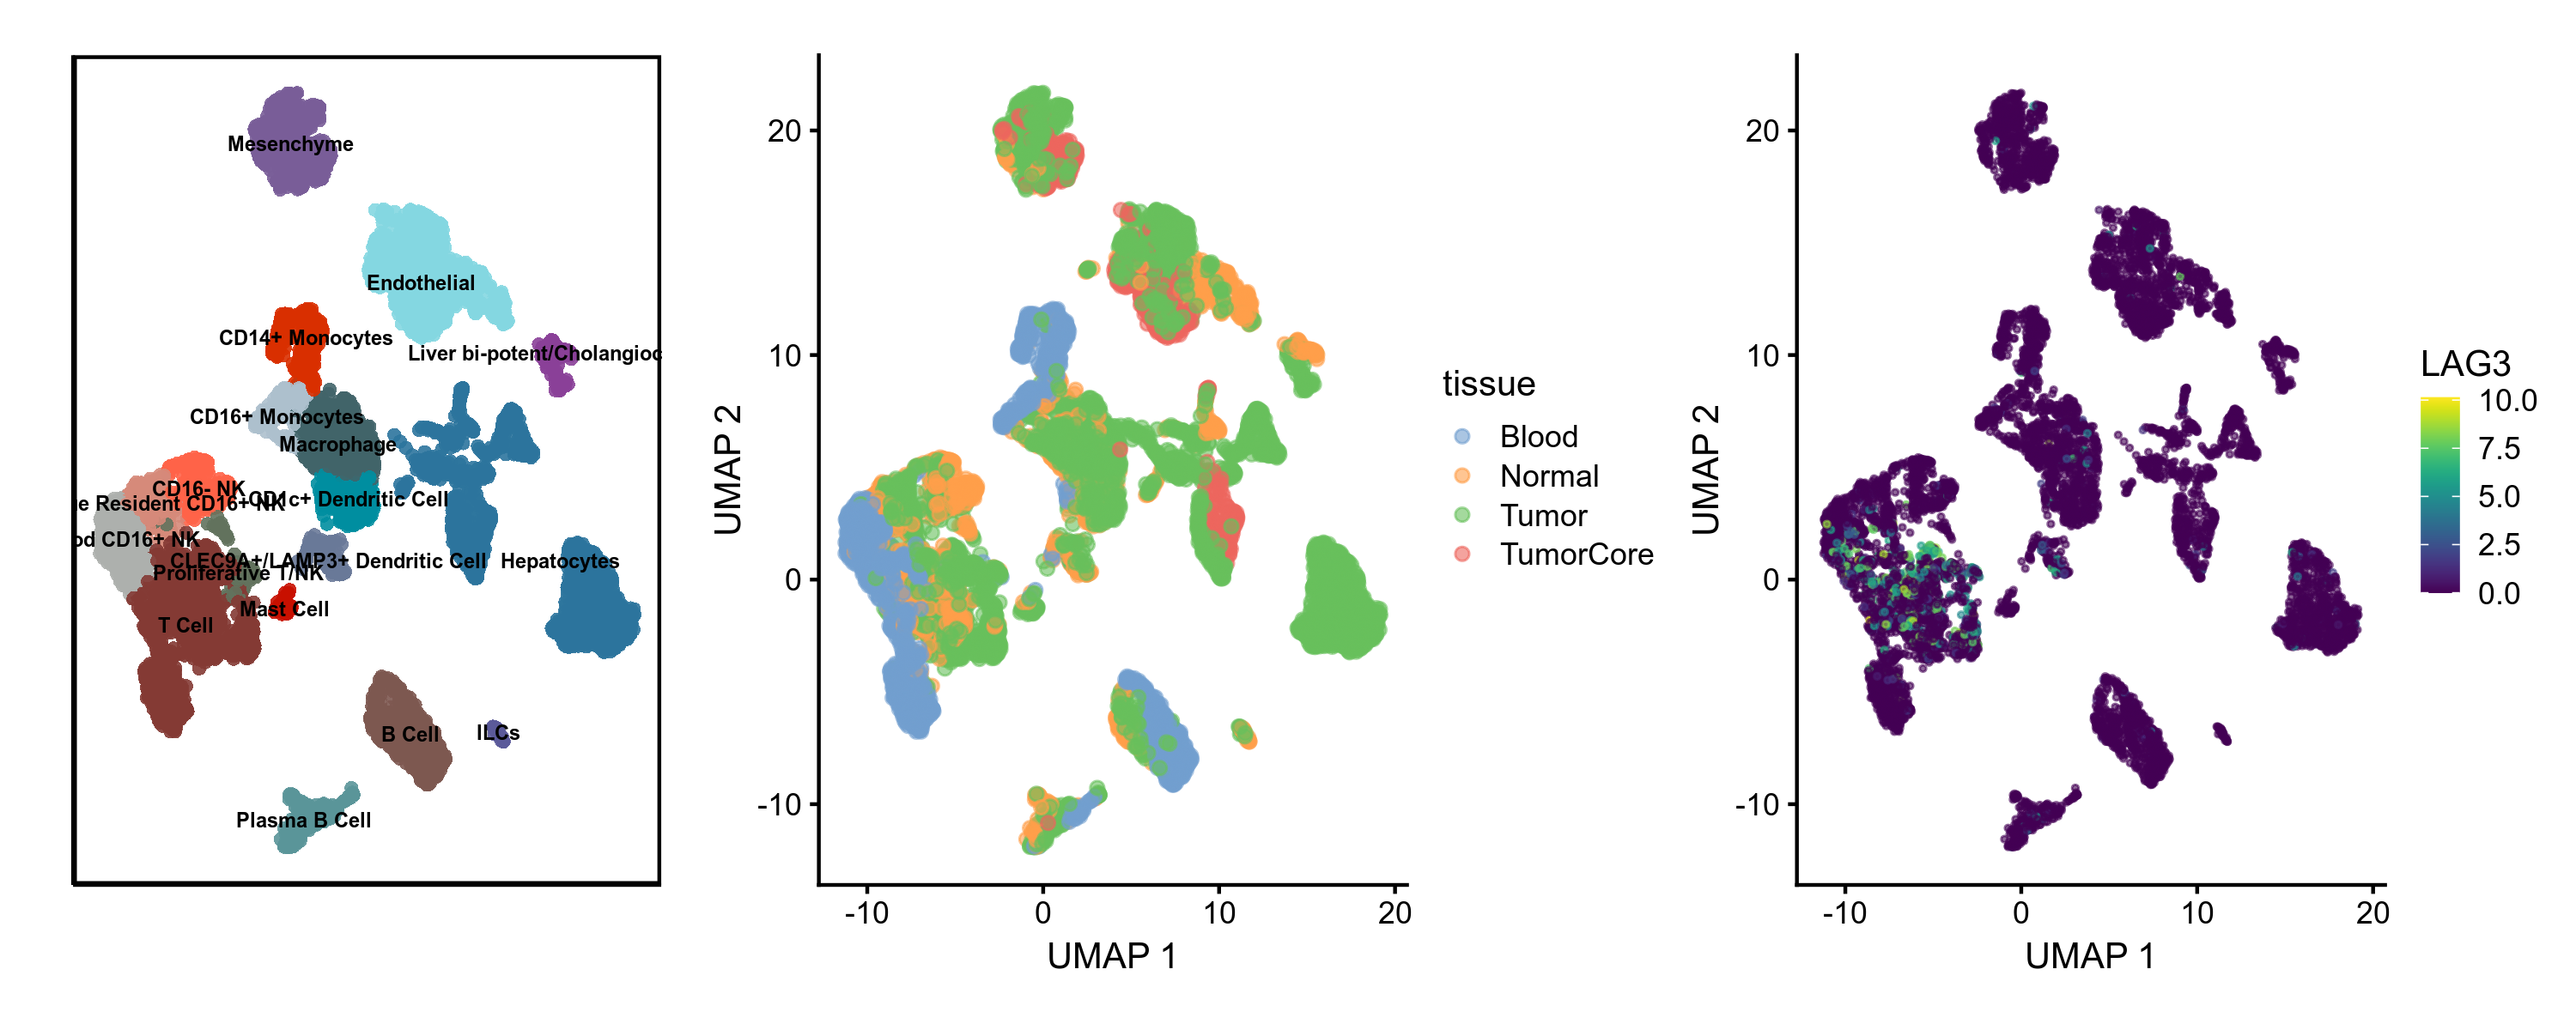

In [284]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
plotDF <- makePerCellDF(sce, use_dimred = T)
plotLabelDF <- plotDF %>% 
    group_by(leiden_global_celltype) %>%
    summarise(UMAP.1 = median(UMAP.1),
              UMAP.2 = median(UMAP.2))

p1 <- ggcells(sce, aes(x=UMAP.1, y = UMAP.2) ) + 
    geom_point(aes(color = leiden_global_celltype), shape = 16, alpha = 0.9, size = 1.5) +
    #geom_point(data = plotLabelDF, shape = 21, fill = 'white', alpha = .8, color = 'snow', size = 8) +
    geom_text(data = plotLabelDF, aes(label = leiden_global_celltype), color = 'black', size = 2, fontface = 'bold') +
    scale_color_manual(values = cols, guide = guide_legend(title = NULL,override.aes = list(size = 4))) + 
    ggpubr::theme_pubr(base_size = 20) +
    theme(legend.position = 'none', axis.ticks = element_blank(), axis.text = element_blank(), axis.title = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1))
p3 <- plotUMAP(sce, colour_by = "LAG3", point_size = .5)
p1 + p2 + p3

# Removing doublet 

In [229]:
sce <- sce[, sce$leiden_global_celltype != "Doublet_D20170327"]
sce 

class: SingleCellExperiment 
dim: 60682 9086 
metadata(4): pca neighbors umap leiden
assays(2): logcounts counts
rownames(60682): DDX11L1 WASH7P_ENSG00000227232 ... HPV-mRTRX7 HPV-mSD2
rowData names(10): Geneid Chr ... highly_variable varm
colnames(9086): NL-plus-19-0222 NL-plus-2-0222 ... TP5-95-20180110
  TP5-96-20180110
colData names(27): cell.id cell.type ... leiden_global
  leiden_global_celltype
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):

In [273]:
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered.rds")

In [274]:
sce <- sce[, !(sce$leiden_global_celltype == 'Hepatocytes' & sce$facs == 'CD45+CD3+')]

In [279]:
sce <- sce[, !(sce$leiden_global_celltype == 'Hepatocytes' & sce$facs == 'CD45+')]

In [280]:
table(sce$leiden_global_celltype, sce$facs)

                                
                                 CD45- CD45+ CD45+CD3+
  B Cell                             3   654         0
  Blood CD16+ NK                     0   386       121
  CD14+ Monocytes                    0   370         0
  CD16- NK                           5   303         1
  CD16+ Monocytes                    0   198         0
  CD1c+ Dendritic Cell               0   318         0
  CLEC9A+/LAMP3+ Dendritic Cell      3   114         1
  Endothelial                     1178    11         0
  Hepatocytes                     1468     0         0
  ILCs                               2    35         0
  Liver bi-potent/Cholangiocytes   117     1         0
  Macrophage                         2   573         4
  Mast Cell                          3    55         0
  Mesenchyme                       644     6         0
  Plasma B Cell                     29   239         2
  Proliferative T/NK                 0    30        52
  T Cell                        

In [276]:
table(sce$leiden_global_celltype == 'Hepatocytes' & sce$facs == 'CD45+CD3+')


FALSE 
 9084 

In [285]:
table(sce$leiden_global_celltype)


                        B Cell                 Blood CD16+ NK 
                           657                            507 
               CD14+ Monocytes                       CD16- NK 
                           370                            309 
               CD16+ Monocytes           CD1c+ Dendritic Cell 
                           198                            318 
 CLEC9A+/LAMP3+ Dendritic Cell                    Endothelial 
                           118                           1189 
                   Hepatocytes                           ILCs 
                          1468                             37 
Liver bi-potent/Cholangiocytes                     Macrophage 
                           118                            579 
                     Mast Cell                     Mesenchyme 
                            58                            650 
                 Plasma B Cell             Proliferative T/NK 
                           270                        

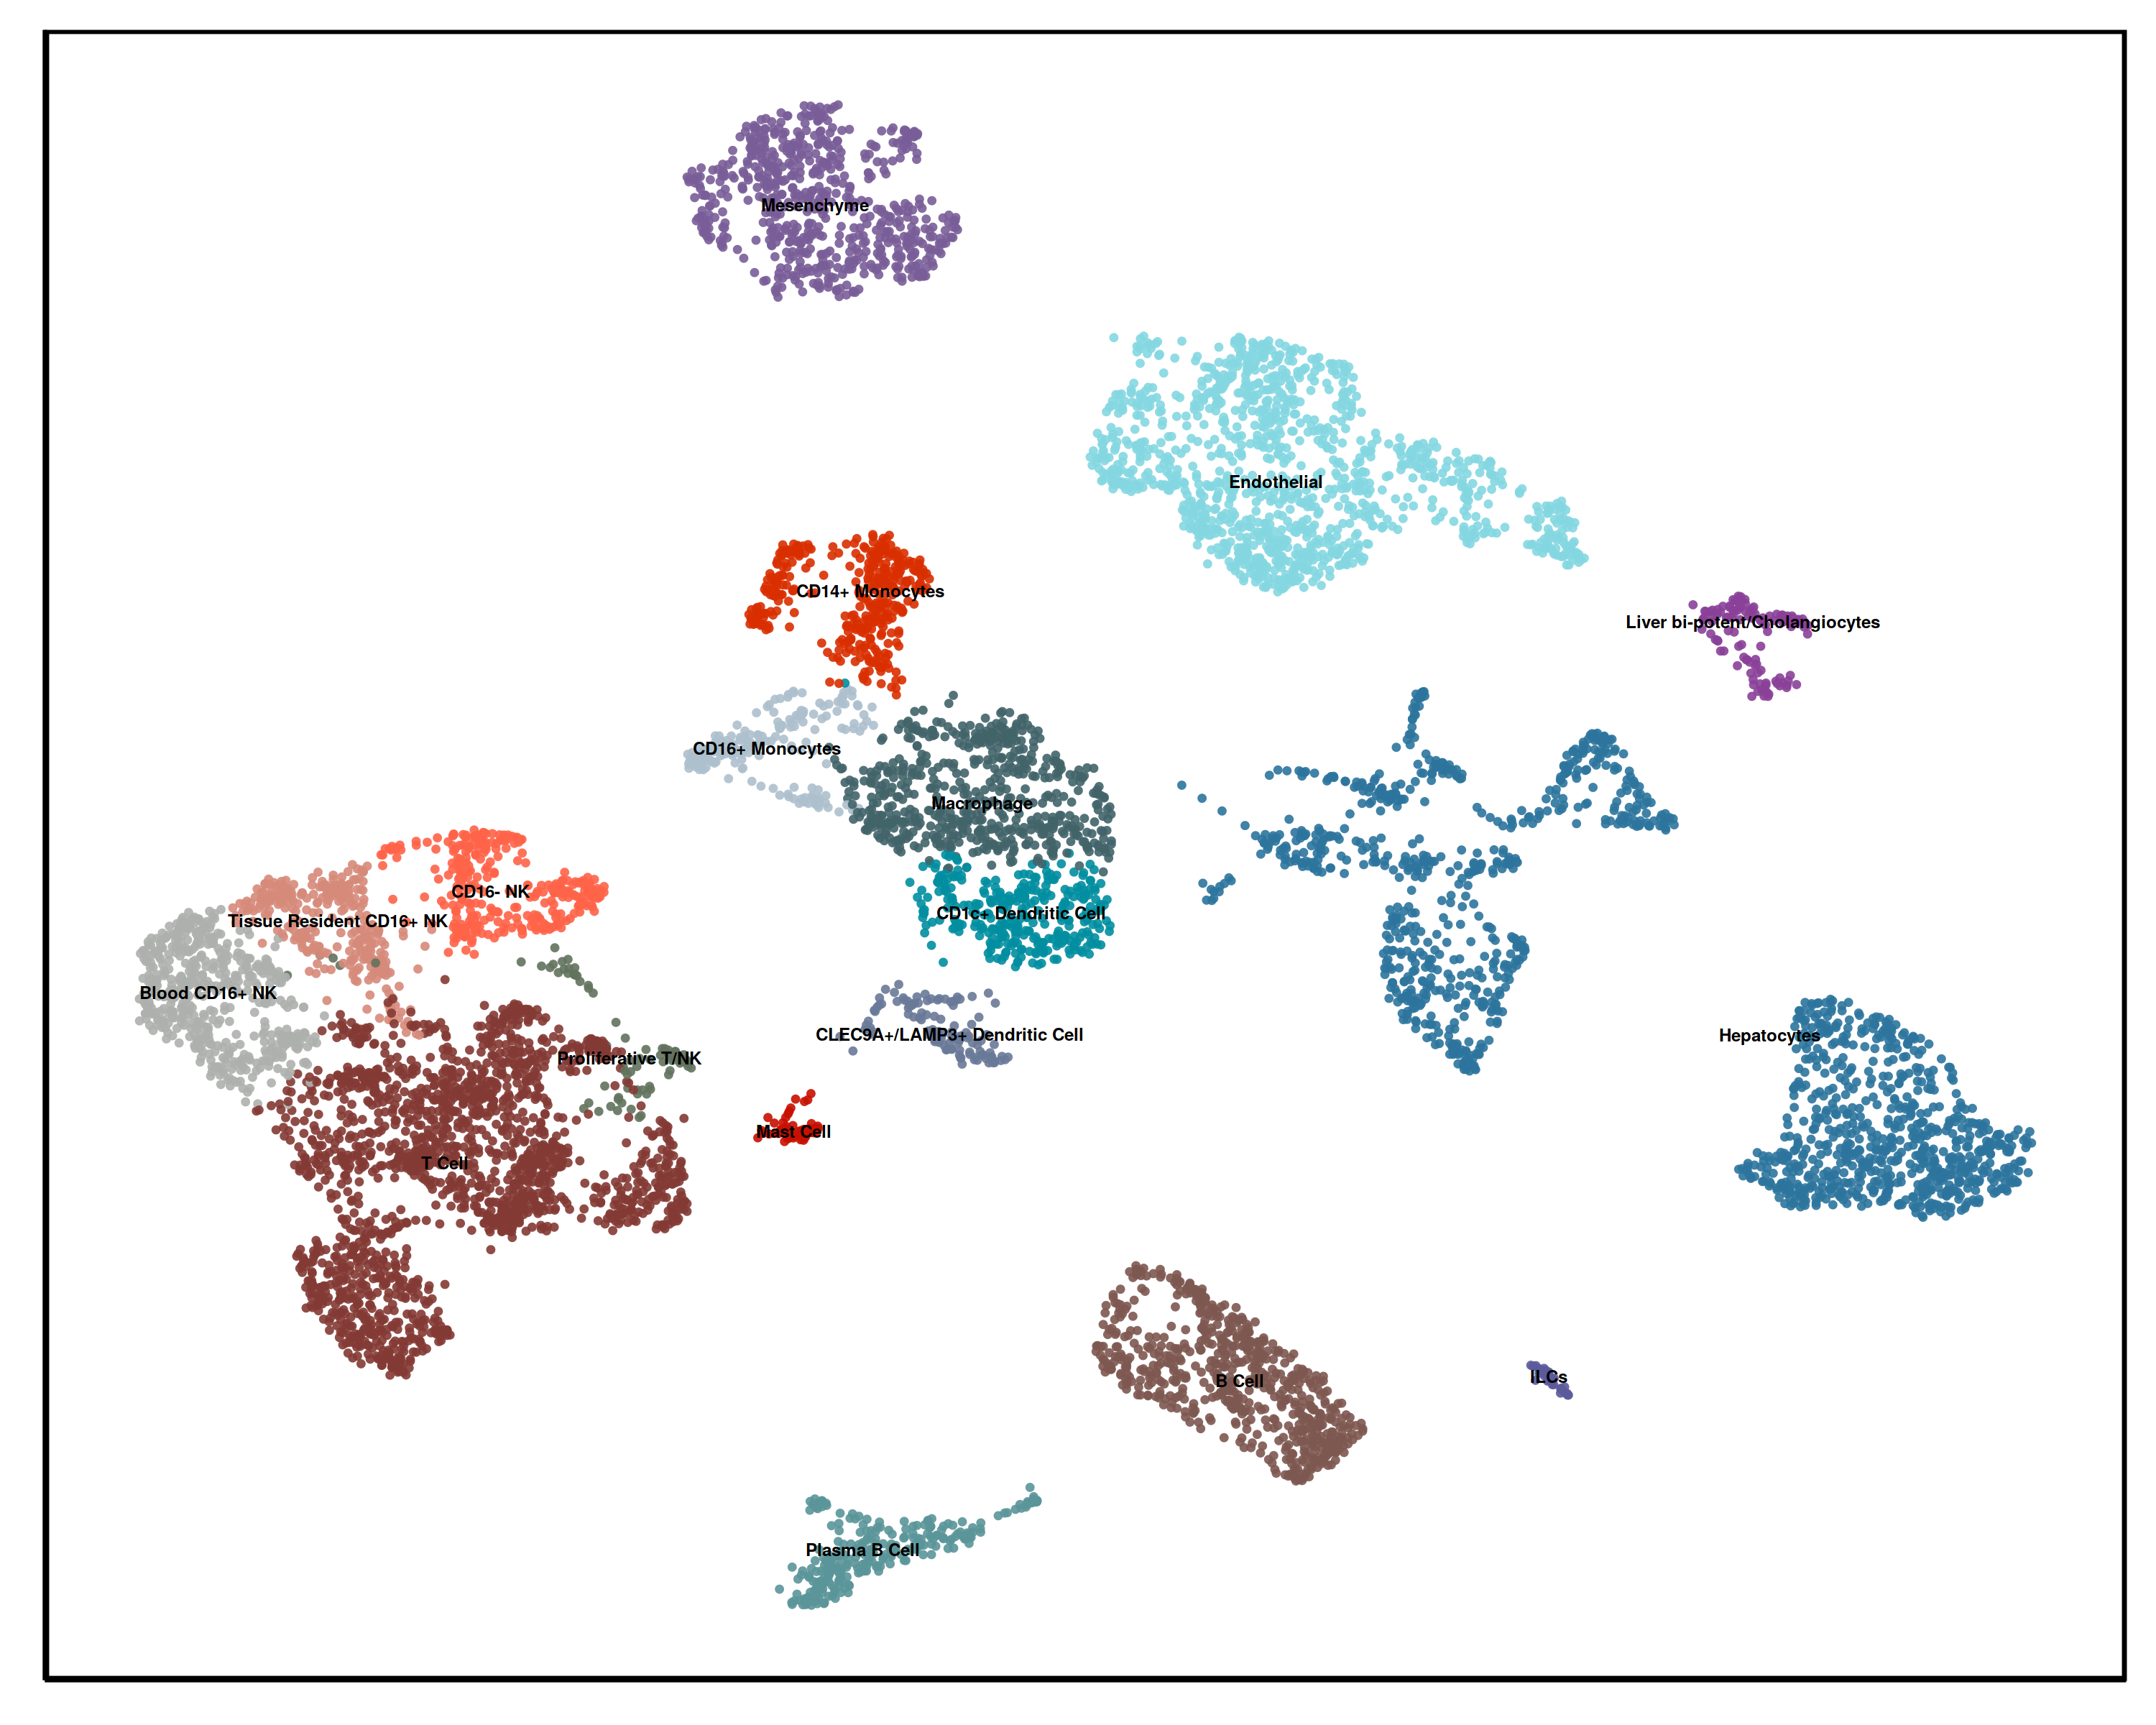

In [6]:
plotDF <- makePerCellDF(sce, use_dimred = T)
plotLabelDF <- plotDF %>% 
    group_by(leiden_global_celltype) %>%
    summarise(UMAP.1 = median(UMAP.1),
              UMAP.2 = median(UMAP.2))
p1 <- ggcells(sce, aes(x=UMAP.1, y = UMAP.2) ) + 
    geom_point(aes(color = leiden_global_celltype), shape = 16, alpha = 0.9, size = 1) +
    #geom_point(data = plotLabelDF, shape = 21, fill = 'white', alpha = .8, color = 'snow', size = 8) +
    geom_text(data = plotLabelDF, aes(label = leiden_global_celltype), color = 'black', size = 2, fontface = 'bold') +
    scale_color_manual(values = cols, guide = guide_legend(title = NULL,override.aes = list(size = 4))) + 
    ggpubr::theme_pubr(base_size = 20) +
    theme(legend.position = 'none', axis.ticks = element_blank(), axis.text = element_blank(), axis.title = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1))

p1

In [7]:
ggsave(p1, filename = "./figure1C.pdf")

Saving 6.67 x 6.67 in image



# Writing Out

In [3]:
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered.rds")

In [287]:
saveRDS(sce, file = "../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered.rds")